# Import Necessary Functions and Packages

We import the packages we need and also set our schema to be able to pull data from the SQL database. We also immediately use our stored get_engine function to be able to establish a connection to our database.

In [1]:
import pandas as pd
import numpy as np
import psycopg2 
from sql_functions import get_engine
from sql_functions import get_dataframe 
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

schema= 'capstone_crime_nerds'
engine = get_engine()

# Pulling data from SQL Database

## Crime Data

In [2]:
crimes_by_offense = get_dataframe(f'select borough, extract(year from report_date) as year, extract(month from report_date) as month, offense, count(*) from {schema}.criminal_data_new group by 1,2,3,4')

In [3]:
crimes_by_offense

,borough,year,month,offense,count
0,Bronx,2006.0,1.0,ADMINISTRATIVE CODE,14
1,Bronx,2006.0,1.0,ALCOHOLIC BEVERAGE CONTROL LAW,4
2,Bronx,2006.0,1.0,ARSON,51
3,Bronx,2006.0,1.0,ASSAULT 3 & RELATED OFFENSES,929
4,Bronx,2006.0,1.0,BURGLARY,359
...,...,...,...,...,...
45056,Staten Island,2023.0,12.0,ROBBERY,22
45057,Staten Island,2023.0,12.0,SEX CRIMES,27
45058,Staten Island,2023.0,12.0,THEFT-FRAUD,17
45059,Staten Island,2023.0,12.0,UNAUTHORIZED USE OF A VEHICLE,17


In [5]:
crimes_by_offense.columns

Index(['borough', 'year', 'month', 'offense', 'count'], dtype='object')

## Economy Data

In [7]:
economy_data = get_dataframe(f'select * from {schema}.economy_data')

In [8]:
economy_data

,borough,year,month,crime_type,total_crimes,median_rent,median_yearly_income,median_monthly_income,rent_income_ratio,county,population,crime_ratio,date
0,Bronx,2010,1,Felony,2252,1600.0,34264,2855.333333,0.560355,"Bronx County, New York",1365725,164.894104,2010-01-01
1,Bronx,2010,1,Misdemeanor,6074,1600.0,34264,2855.333333,0.560355,"Bronx County, New York",1365725,444.745465,2010-01-01
2,Bronx,2010,1,Violation,1062,1600.0,34264,2855.333333,0.560355,"Bronx County, New York",1365725,77.760896,2010-01-01
3,Bronx,2010,2,Felony,1823,1600.0,34264,2855.333333,0.560355,"Bronx County, New York",1365725,133.482216,2010-02-01
4,Bronx,2010,2,Misdemeanor,5000,1600.0,34264,2855.333333,0.560355,"Bronx County, New York",1365725,366.105914,2010-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,Staten Island,2023,11,Misdemeanor,1178,2249.0,101528,8460.666667,0.265818,"Richmond County, New York",495600,237.691687,2023-11-01
2516,Staten Island,2023,11,Violation,387,2249.0,101528,8460.666667,0.265818,"Richmond County, New York",495600,78.087167,2023-11-01
2517,Staten Island,2023,12,Felony,521,2253.0,101528,8460.666667,0.266291,"Richmond County, New York",495600,105.125101,2023-12-01
2518,Staten Island,2023,12,Misdemeanor,1131,2253.0,101528,8460.666667,0.266291,"Richmond County, New York",495600,228.208232,2023-12-01


In [9]:
economy_data.columns

Index(['borough', 'year', 'month', 'crime_type', 'total_crimes', 'median_rent',
       'median_yearly_income', 'median_monthly_income', 'rent_income_ratio',
       'county', 'population', 'crime_ratio', 'date'],
      dtype='object')

# Initial Data Cleanup

Changing the type of the date months to integer.

In [4]:
crimes_by_offense['month'] = crimes_by_offense['month'].astype(int)
crimes_by_offense['year'] = crimes_by_offense['year'].astype(int)


We will now aggregate the economy data so we can see the total crimes per month as opposed to in their specific severity categories. All other values we can just use the 'First' aggregation to retain the first value as the value stays constant during this time. We could achieve the same result by using mean, median, mode, min or max but the First aggregation uses very little computing power in comparison.

In [10]:
aggregations = {
    'total_crimes': 'sum',
    'median_rent': 'first',
    'median_yearly_income': 'first',
    'median_monthly_income': 'first',
    'rent_income_ratio': 'first',
    'population': 'first'
}

economy_data_agg = economy_data.groupby(['county', 'borough', 'date', 'year', 'month']).agg(aggregations).reset_index()
economy_data_agg.median_monthly_income = round(economy_data_agg.median_monthly_income, 2)

The result is a data frame that includes one row per month in our time-frame. We can use mathematics to evaluate it's completeness. 

840 rows / 12 Months / 5 Boroughs = 14 years. 

In [11]:
economy_data_agg

,county,borough,date,year,month,total_crimes,median_rent,median_yearly_income,median_monthly_income,rent_income_ratio,population
0,"Bronx County, New York",Bronx,2010-01-01,2010,1,9388,1600.0,34264,2855.33,0.560355,1365725
1,"Bronx County, New York",Bronx,2010-02-01,2010,2,7713,1600.0,34264,2855.33,0.560355,1365725
2,"Bronx County, New York",Bronx,2010-03-01,2010,3,9403,1508.0,34264,2855.33,0.528134,1365725
3,"Bronx County, New York",Bronx,2010-04-01,2010,4,9484,1508.0,34264,2855.33,0.528134,1365725
4,"Bronx County, New York",Bronx,2010-05-01,2010,5,9941,1600.0,34264,2855.33,0.560355,1365725
...,...,...,...,...,...,...,...,...,...,...,...
835,"Richmond County, New York",Staten Island,2023-08-01,2023,8,2170,2000.0,101528,8460.67,0.236388,495600
836,"Richmond County, New York",Staten Island,2023-09-01,2023,9,1935,2125.0,101528,8460.67,0.251162,495600
837,"Richmond County, New York",Staten Island,2023-10-01,2023,10,2220,2200.0,101528,8460.67,0.260027,495600
838,"Richmond County, New York",Staten Island,2023-11-01,2023,11,2124,2249.0,101528,8460.67,0.265818,495600


# Data Analysis

We can now calculate our crime ratio. This tells us the amount of crimes per 100,000 people. The following calculation is used:
- total crimes / population * 100,000.

In [12]:
economy_data_agg['crime_ratio'] = (economy_data_agg['total_crimes'] / economy_data_agg['population']) * 100000

Now that we have our crime ratio and rent income ratio (rent burden ratio) calculated together we can use the .corr method to investigate the relationship of these variables through pearsons coefficient.

In [13]:
ratio_correlation = economy_data_agg['rent_income_ratio'].corr(economy_data_agg['crime_ratio'])

print(f"The correlation between rent_income_ratio and crime_ratio is approximately {ratio_correlation:.4f}.")

The correlation between rent_income_ratio and crime_ratio is approximately 0.6087.


Now that we have the overall pearsons coefficient, we would also like to examine how this differs before and after covid. For this, we can run the following code block which will created a new data frame filtering only the dates between the ones we specify below. 

We call this new data pre_covid.

In [15]:
start_date = '2010-01-01'
end_date = '2019-12-31'
pre_covid = economy_data_agg[(economy_data_agg['date'] >= start_date) & (economy_data_agg['date'] <= end_date)]

We will do the same for the post-covid time-frame as well and call this post_covid.

In [16]:
start_date2 = '2020-01-01'
end_date2 = '2023-12-31'
post_covid = economy_data_agg[(economy_data_agg['date'] >= start_date2) & (economy_data_agg['date'] <= end_date2)]

We can now examine the relationship between the data from before covid using the same correlation method as before. We find a pearsons coefficient of 0.5645 indicating a moderate positive relationship between the two variables.

In [17]:
ratio_correlation2 = pre_covid['rent_income_ratio'].corr(pre_covid['crime_ratio'])

print(f"The pre-covid correlation between rent_income_ratio and crime_ratio is approximately {ratio_correlation2:.4f}.")

The pre-covid correlation between rent_income_ratio and crime_ratio is approximately 0.5654.


Repeating the method for the post-covid data gives us an even greater relationship between the two variables. The pearsons coefficient between these two post-covid is 0.7045.

In [18]:
ratio_correlation3 = post_covid['rent_income_ratio'].corr(post_covid['crime_ratio'])

print(f"The pre-covid correlation between rent_income_ratio and crime_ratio is approximately {ratio_correlation3:.4f}.")

The pre-covid correlation between rent_income_ratio and crime_ratio is approximately 0.7045.


We can also use Matlotlib to create a visualization of this relationship. In the plot below we can see on the y axis, the crime ratio and on the x axis the rent income ratio. Here we can get a good understanding of the relationship.

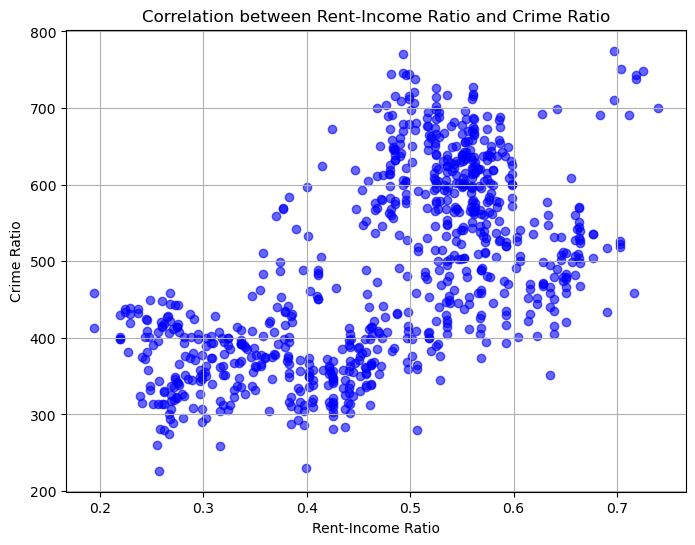

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(economy_data_agg['rent_income_ratio'], economy_data_agg['crime_ratio'], alpha=0.6, color='b')
plt.title("Correlation between Rent-Income Ratio and Crime Ratio")
plt.xlabel("Rent-Income Ratio")
plt.ylabel("Crime Ratio")
plt.grid(True)
plt.show()

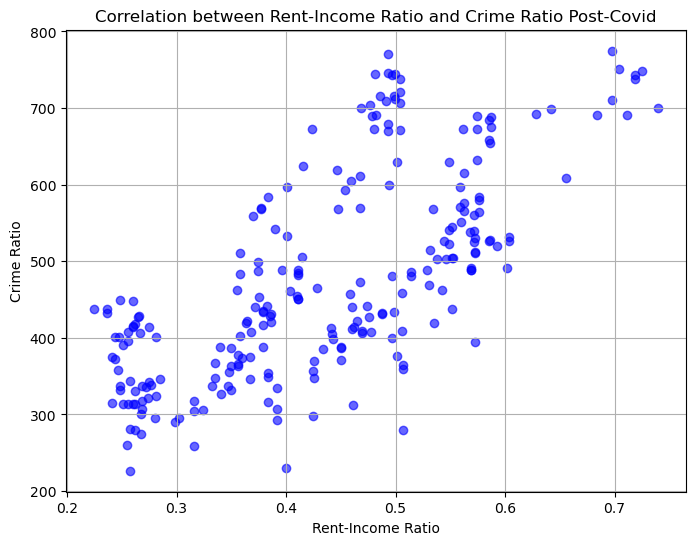

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(post_covid['rent_income_ratio'], post_covid['crime_ratio'], alpha=0.6, color='b')
plt.title("Correlation between Rent-Income Ratio and Crime Ratio Post-Covid")
plt.xlabel("Rent-Income Ratio")
plt.ylabel("Crime Ratio")
plt.grid(True)
plt.show()

# Analysis on Rent Burden's Relationship with Specific Crimes

Now that we have established a moderately strong connection between living costs and crime as a whole, we are going to deep dive into specific crimes and investigate whether some crimes are more strongly correlated with higher livings costs in NYC (and which are not!)

Now we can merge our two data frames together. We are going to merge the crimes_by_offense and our aggregated economy data. We merge on the following columns to logically get the correct data for each borough on the right month and year:
- borough, year, month.

In [21]:

merged_data = pd.merge(economy_data_agg, crimes_by_offense, on=['borough', 'year', 'month'])


We can drop the 'total crimes' column from the  data for now as we are going to use crime figures from specific crimes.

In [22]:
merged_data = merged_data.drop('total_crimes', axis=1)


In [29]:
merged_data.columns

Index(['county', 'borough', 'date', 'year', 'month', 'median_rent',
       'median_yearly_income', 'median_monthly_income', 'rent_income_ratio',
       'population', 'crime_ratio', 'offense', 'count'],
      dtype='object')

In [24]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   county                 35064 non-null  object        
 1   borough                35064 non-null  object        
 2   date                   35064 non-null  datetime64[ns]
 3   year                   35064 non-null  int64         
 4   month                  35064 non-null  int64         
 5   median_rent            34057 non-null  float64       
 6   median_yearly_income   35064 non-null  int64         
 7   median_monthly_income  35064 non-null  float64       
 8   rent_income_ratio      34057 non-null  float64       
 9   population             35064 non-null  int64         
 10  crime_ratio            35064 non-null  float64       
 11  offense                35064 non-null  object        
 12  count                  35064 non-null  int64         
dtypes

We also upload this data frame to our SQL database as we would like to create some visualizations later on using Tableau.

In [25]:
engine = get_engine()
table_name = 'offense_rent_correlation'

if engine!=None:
    try:
        merged_data.to_sql(name=table_name, 
                        con=engine, 
                        if_exists='replace',
                       schema=schema,
                       index=False, 
                        chunksize=5000, 
                       method='multi') 
        print(f"The {table_name} table was imported successfully.")
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The offense_rent_correlation table was imported successfully.


As part of our initial exploratory analysis can use a for loop to create an initial scatter plot for each specific crime in our dataset.

The code below will do the following:
- Loop through every unique value in our data in the 'offense' column. For each offense the code will create a temporary data frame where the offense matches. This will show the total crimes for that particular offense and plot it against the rent_income_ratio. This filtered data is then used to create a scatter plot with the name of the current offense at the top of the plot. This will output a scatter plot for every offense so we can visually get clues about relationships between these figures.

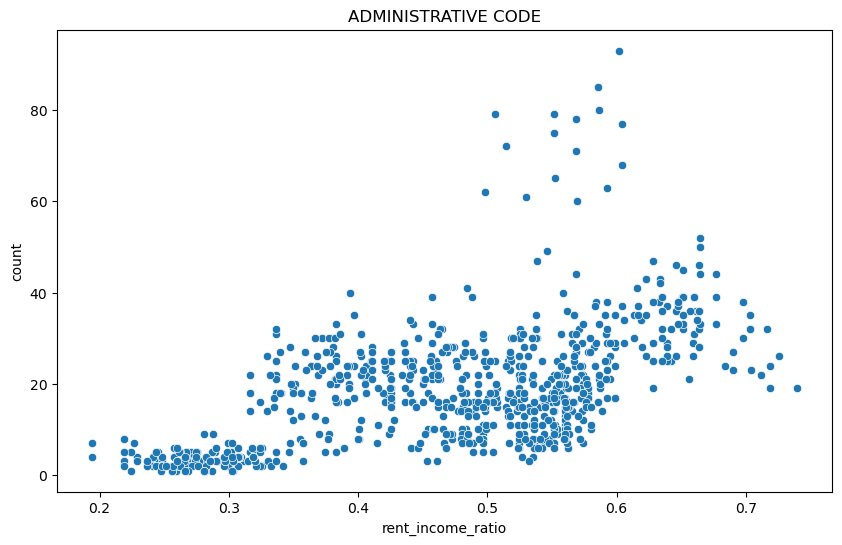

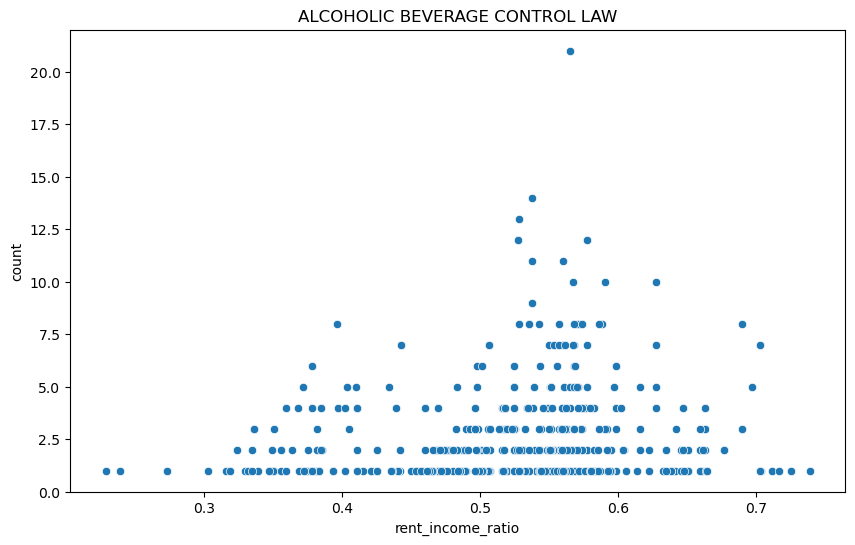

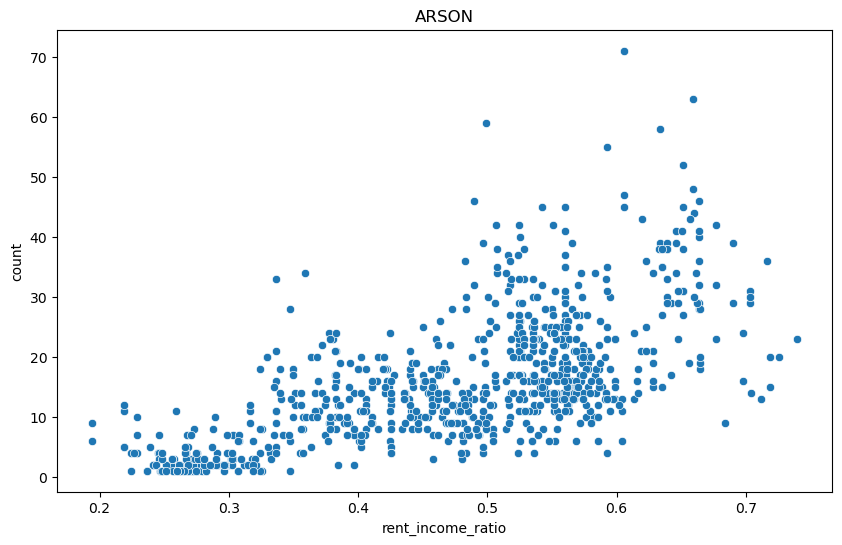

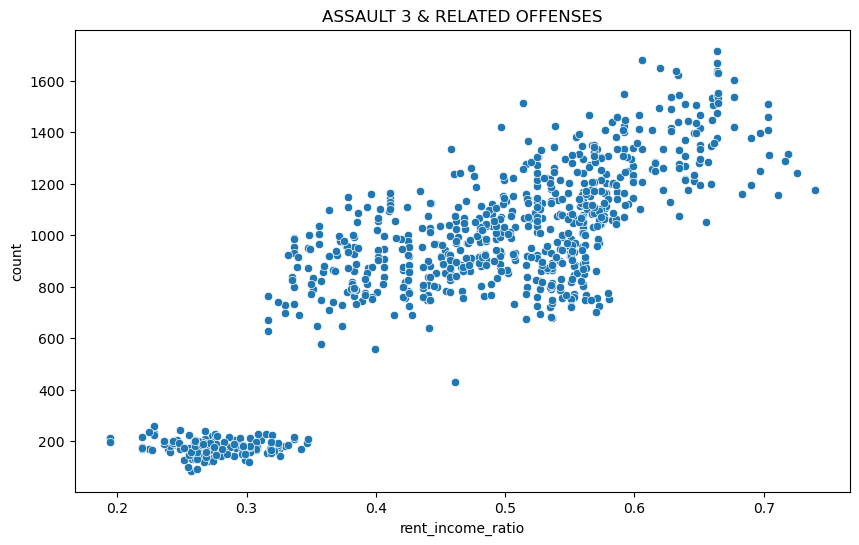

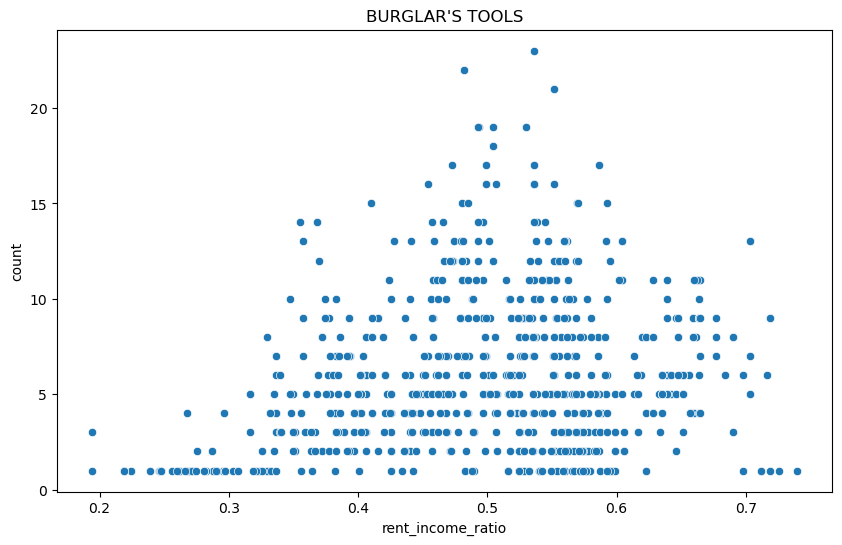

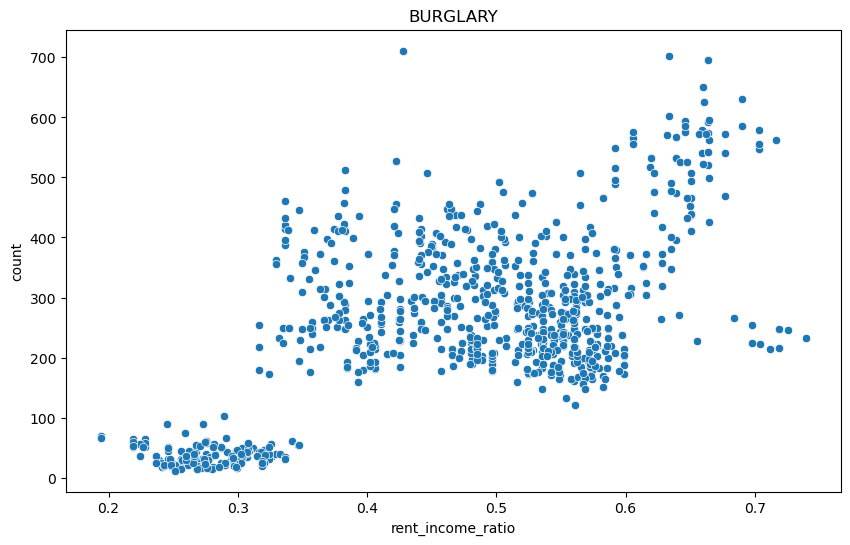

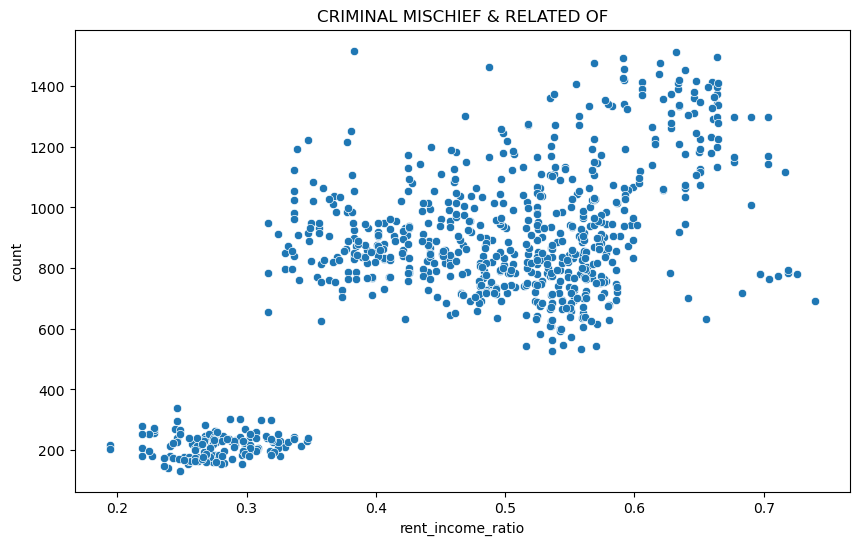

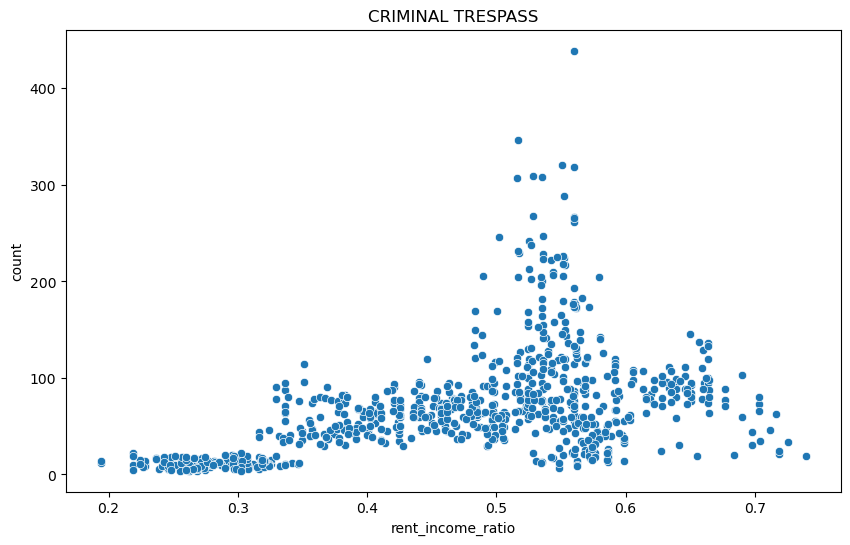

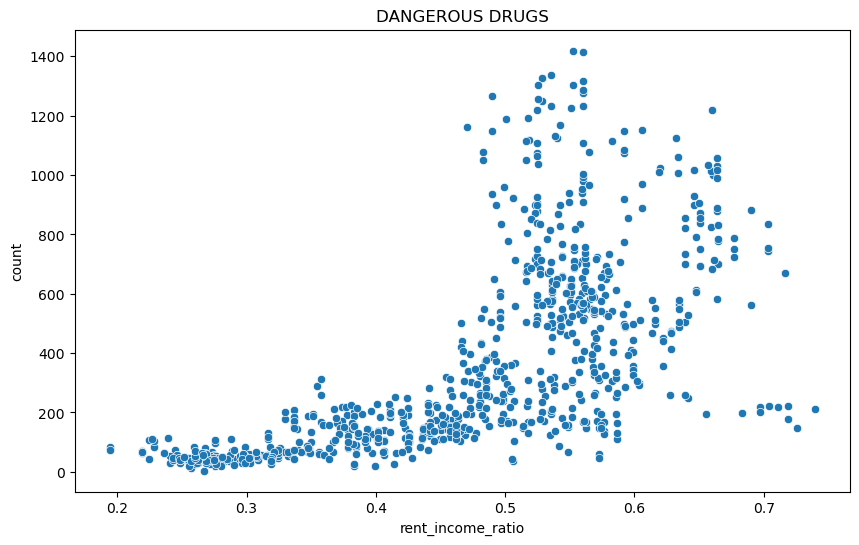

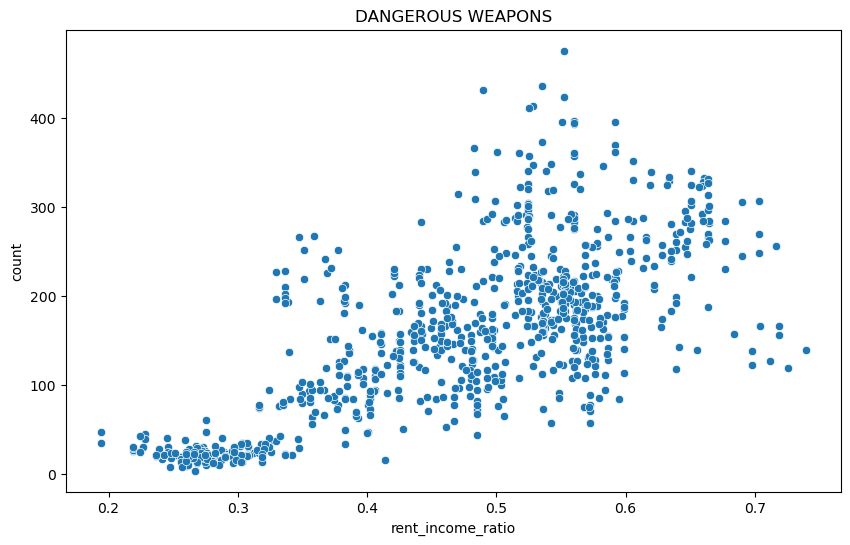

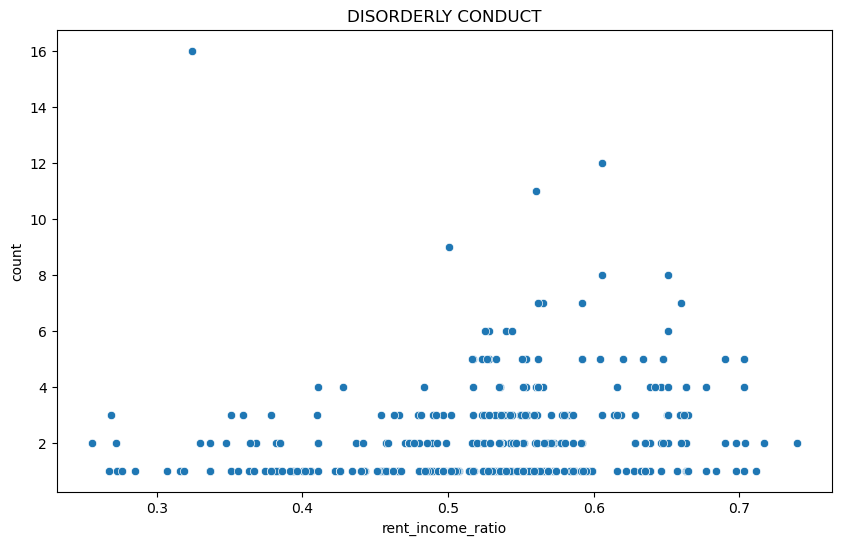

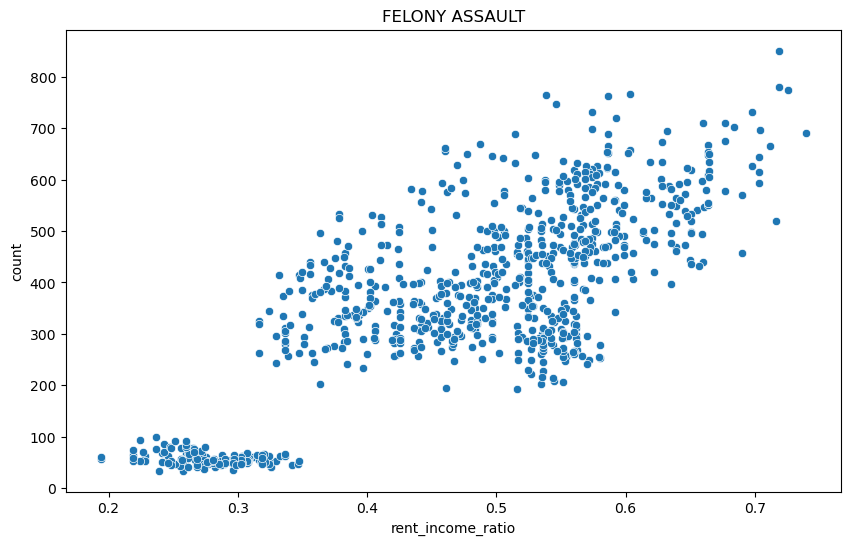

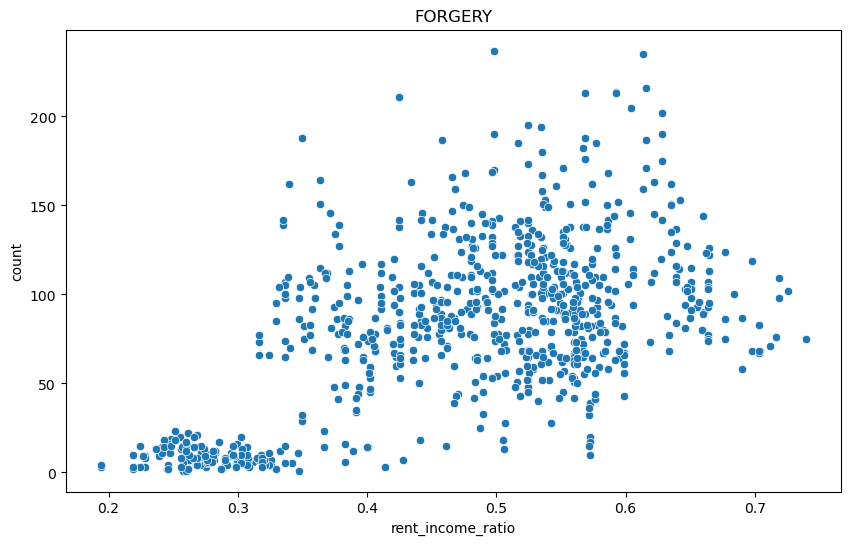

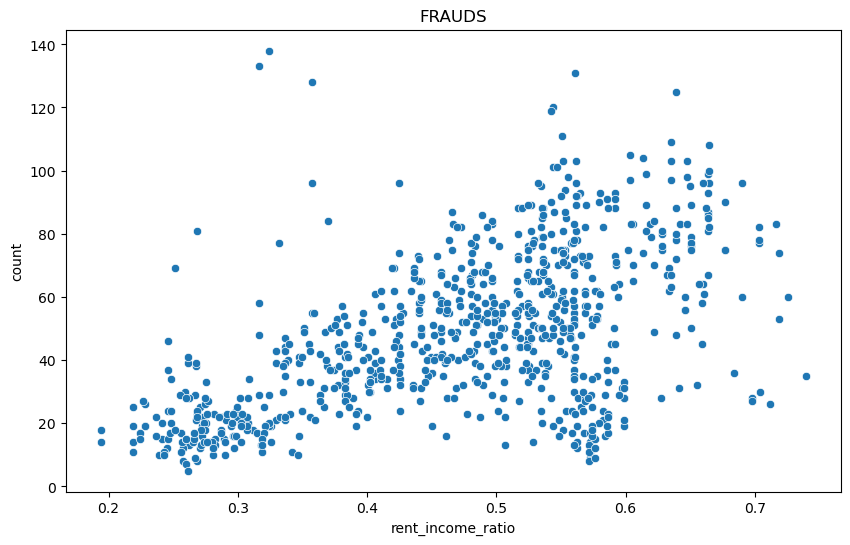

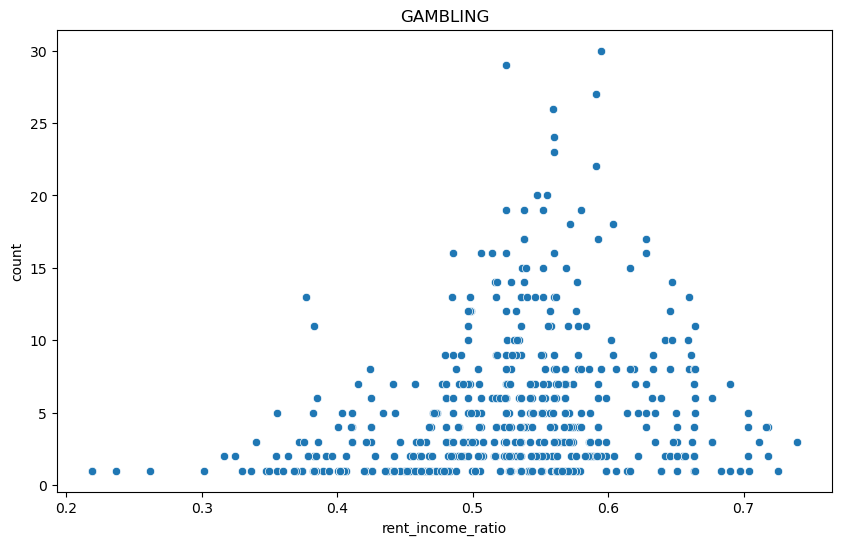

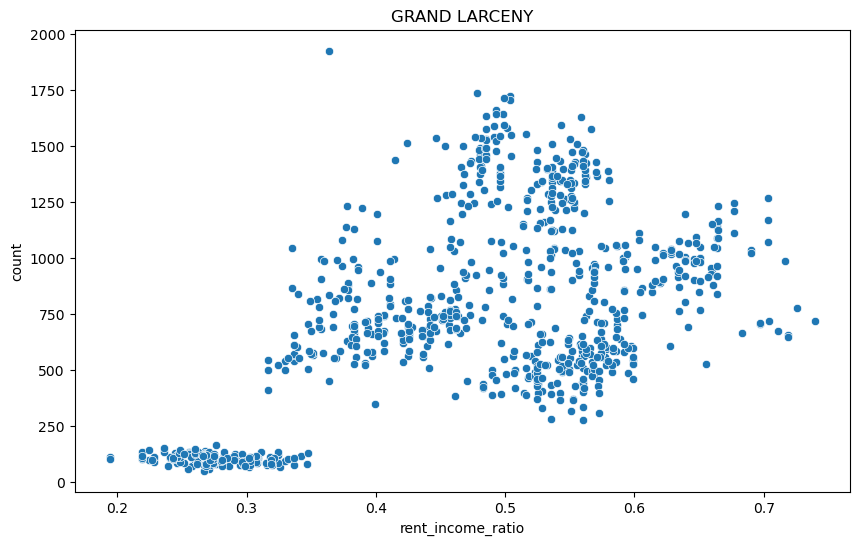

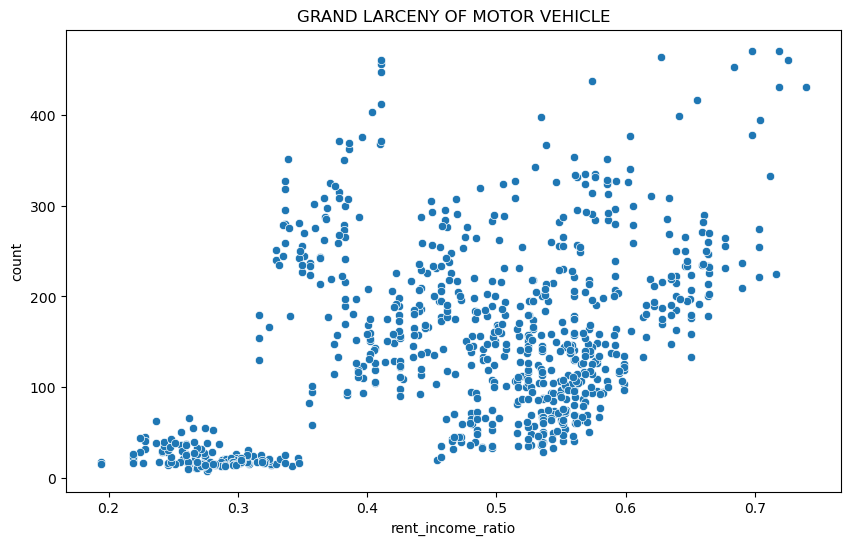

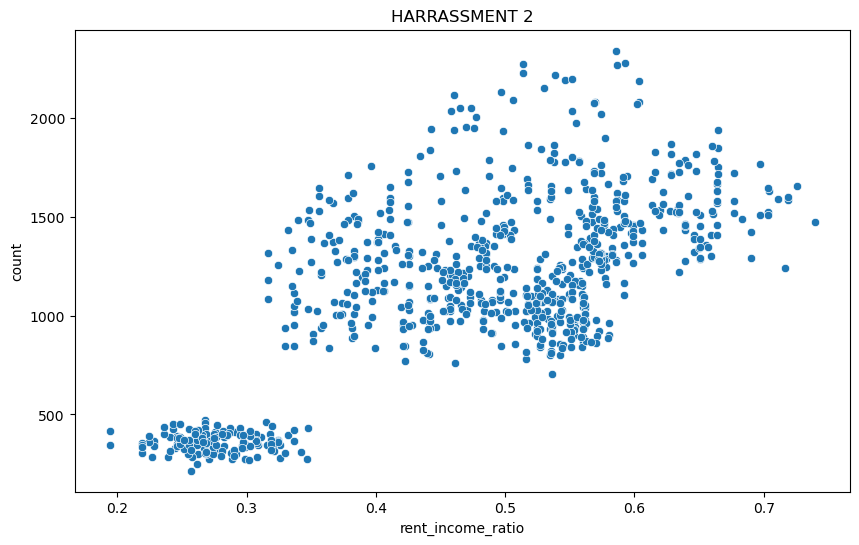

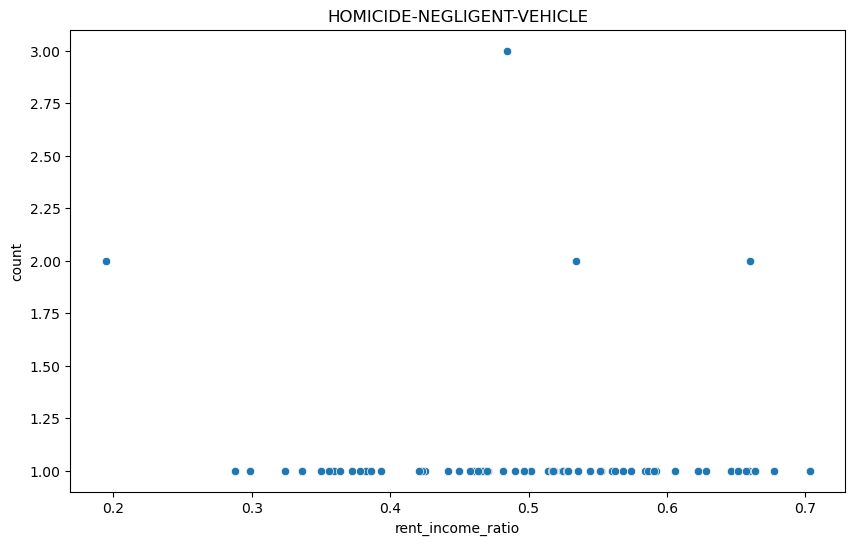

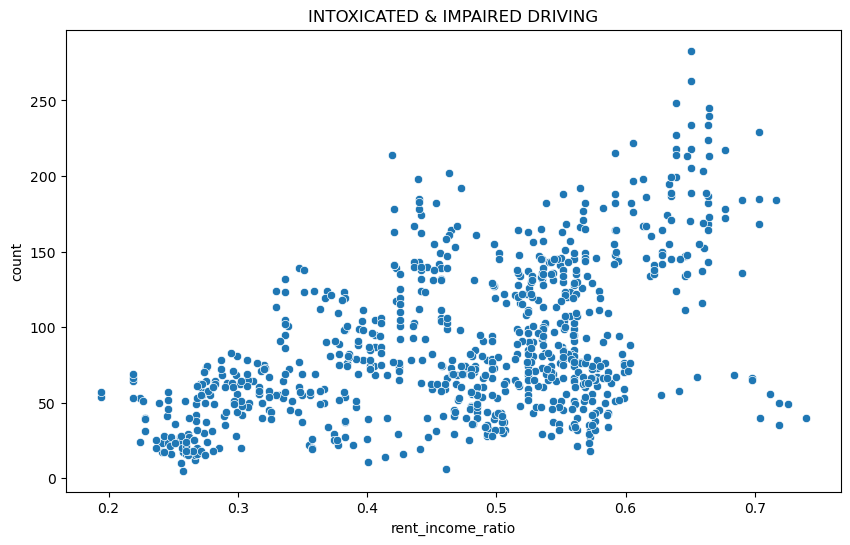

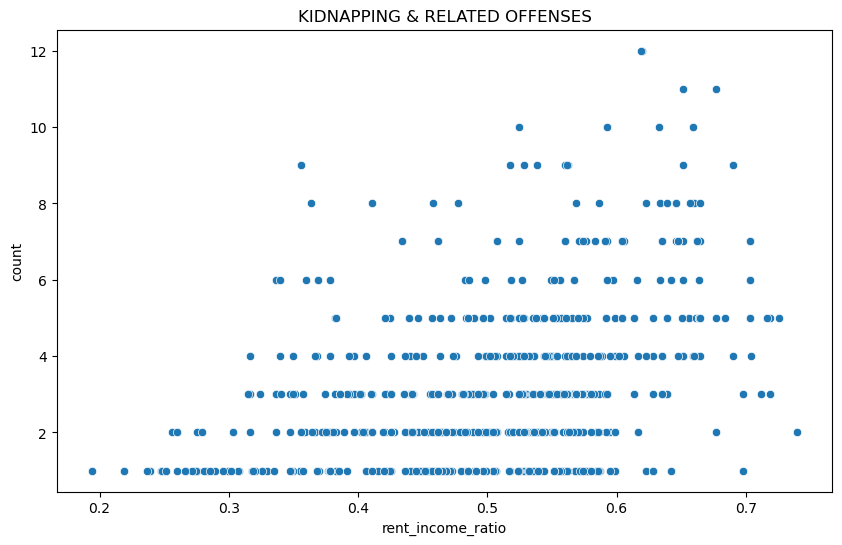

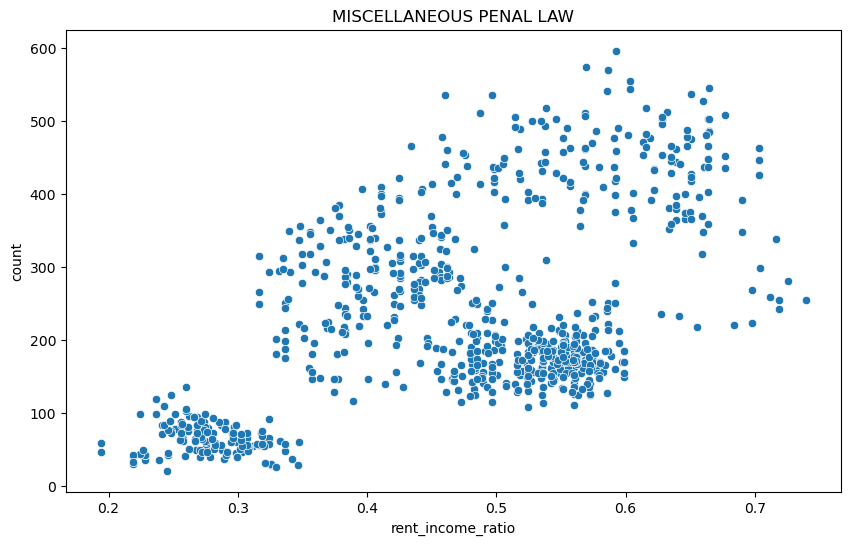

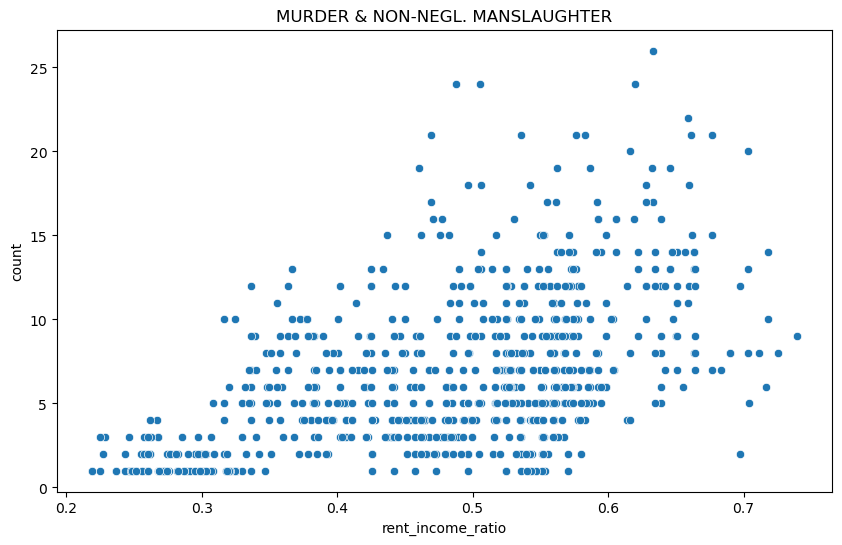

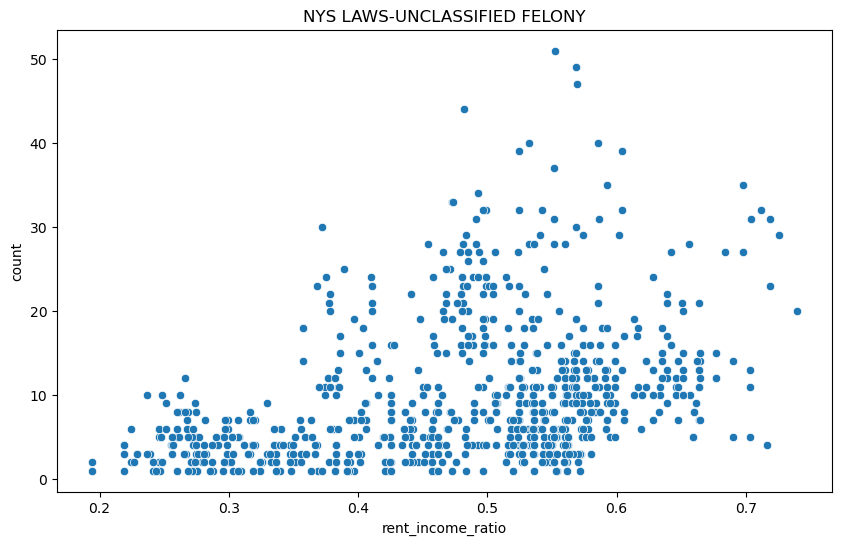

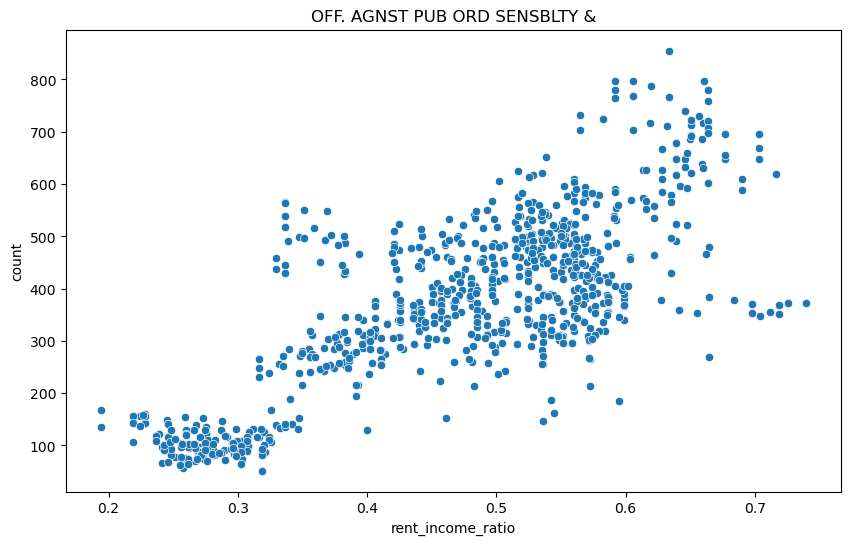

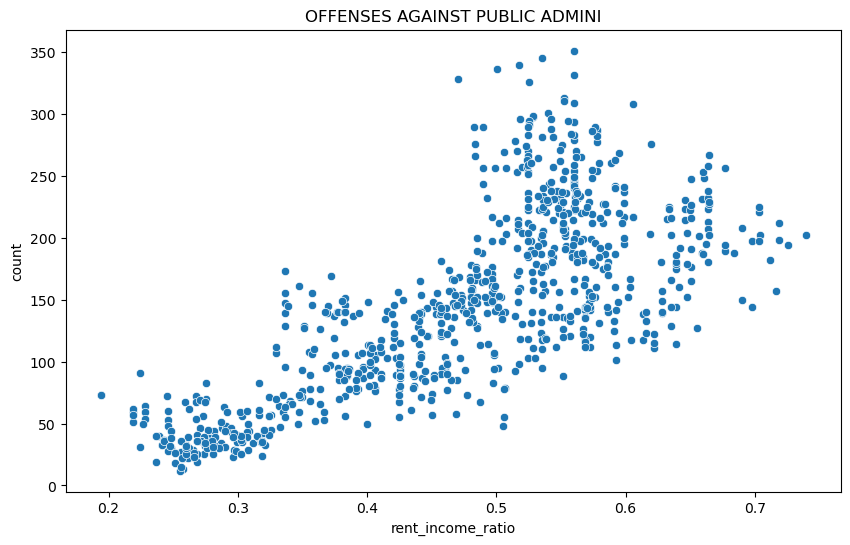

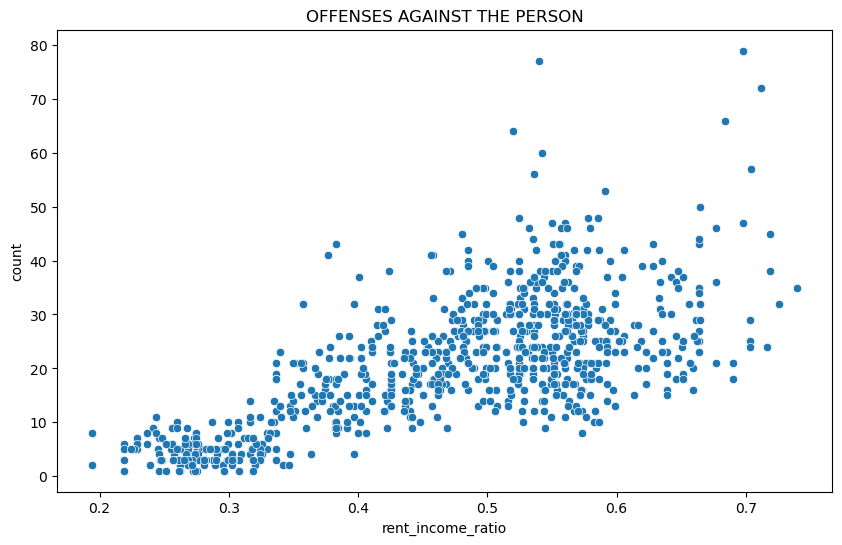

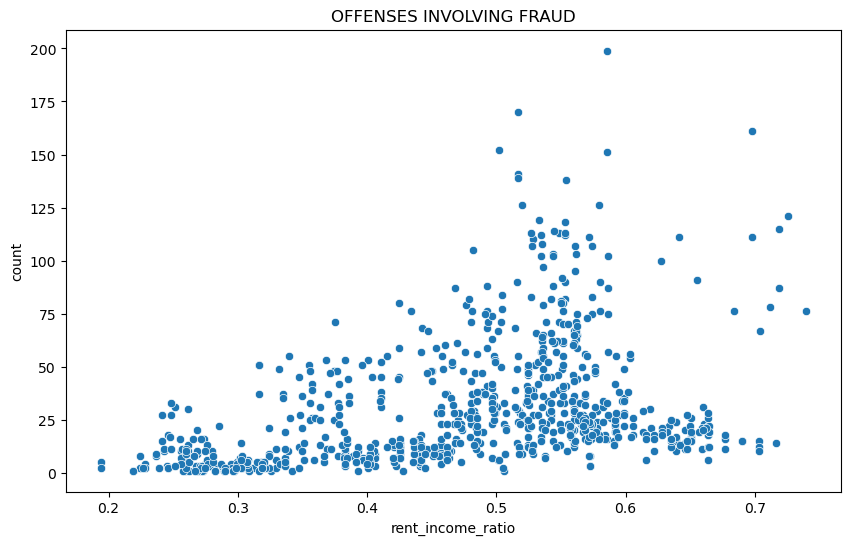

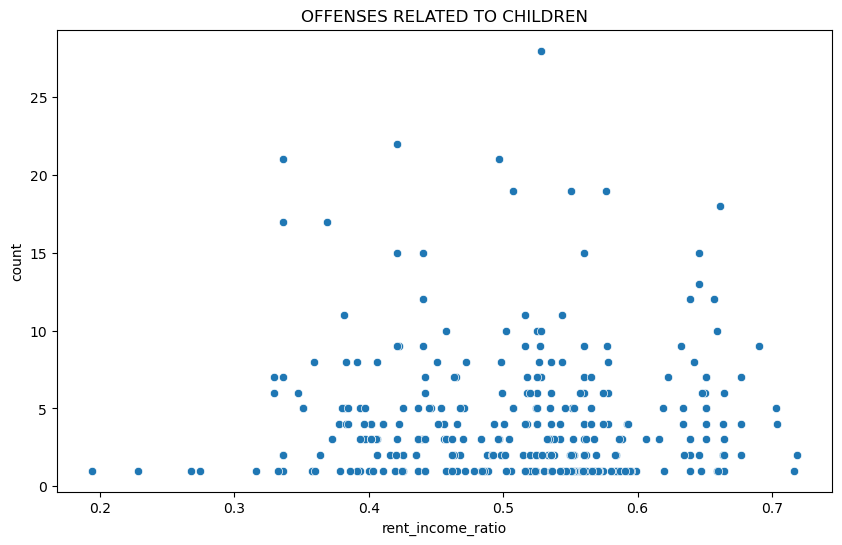

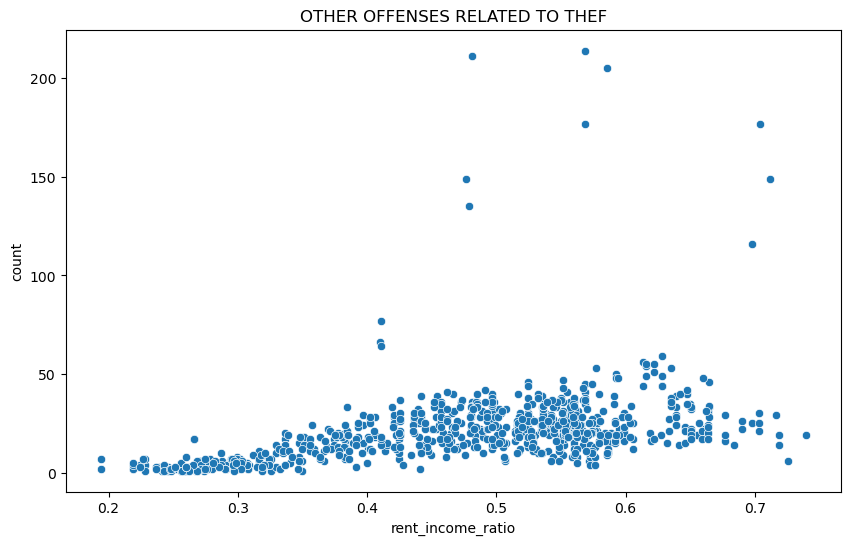

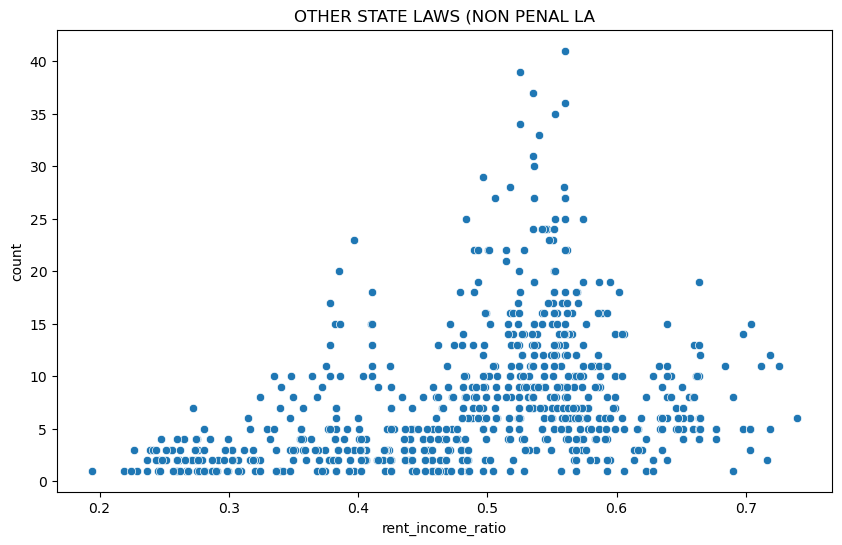

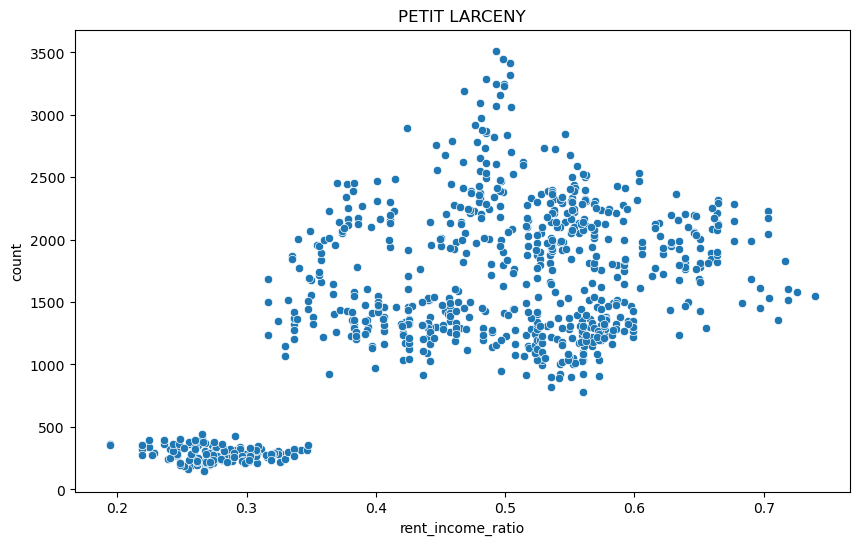

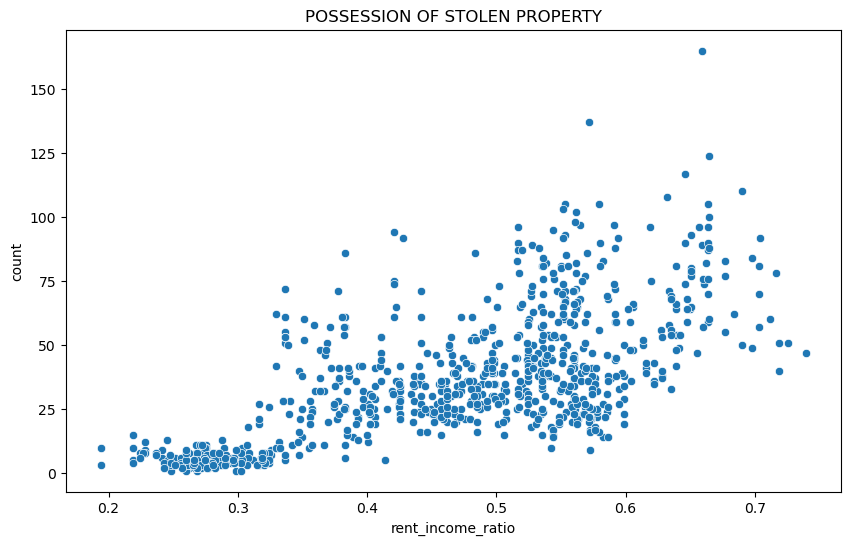

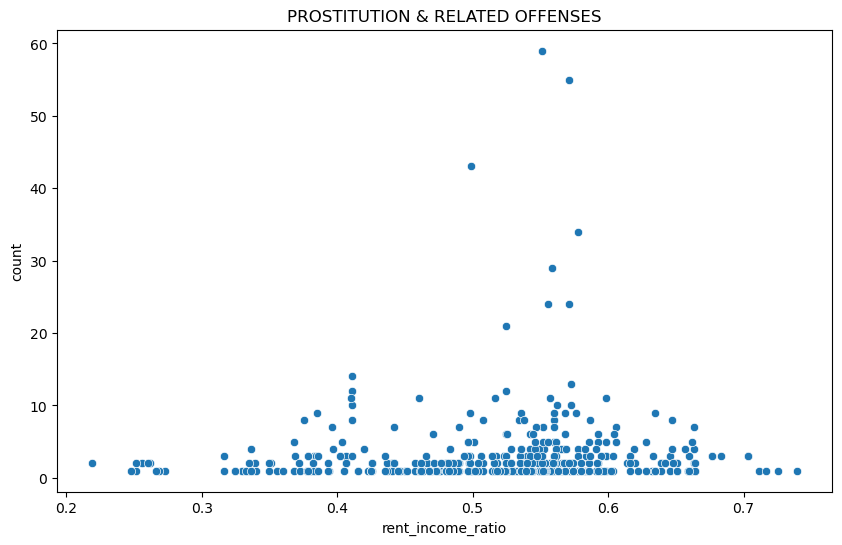

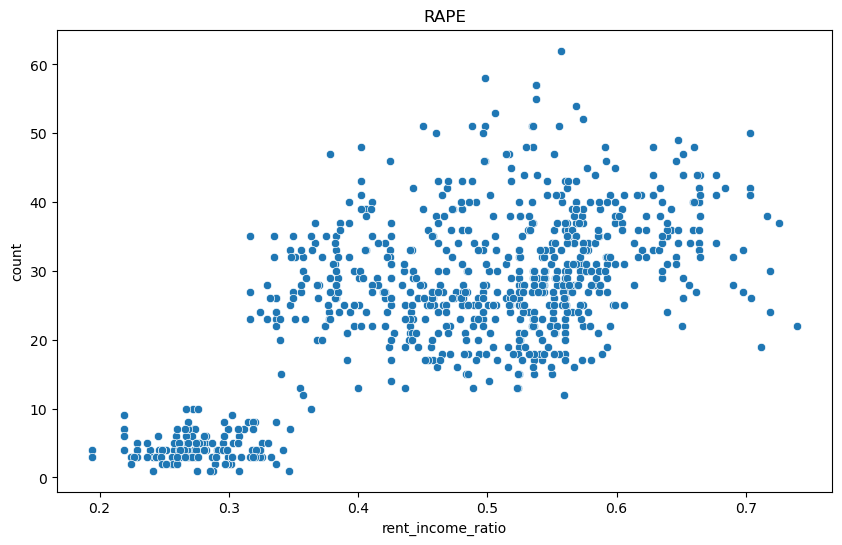

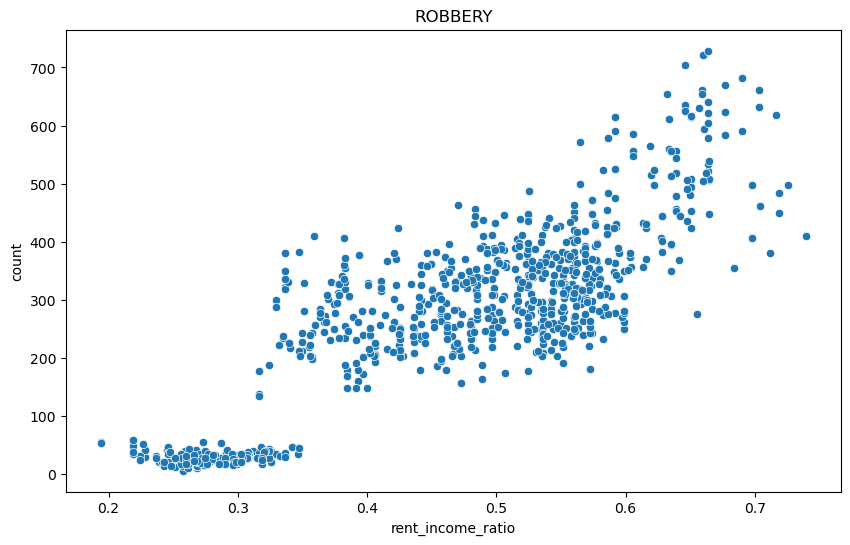

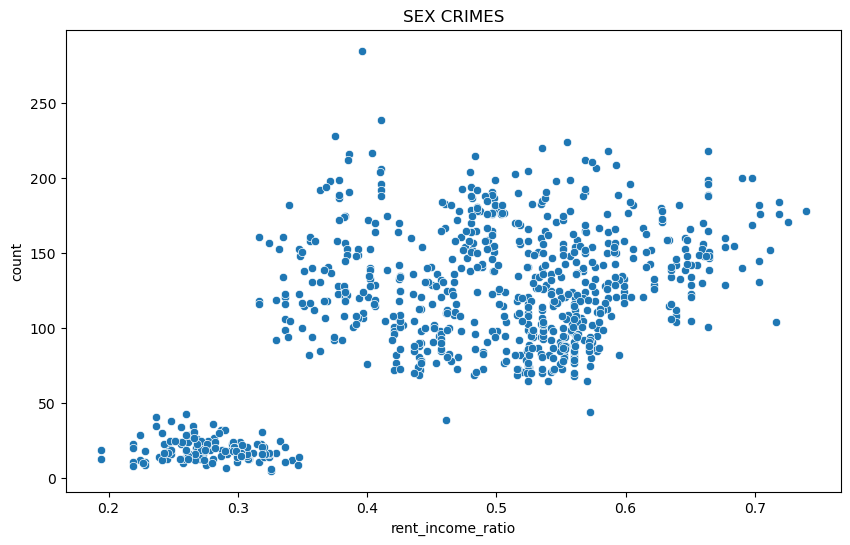

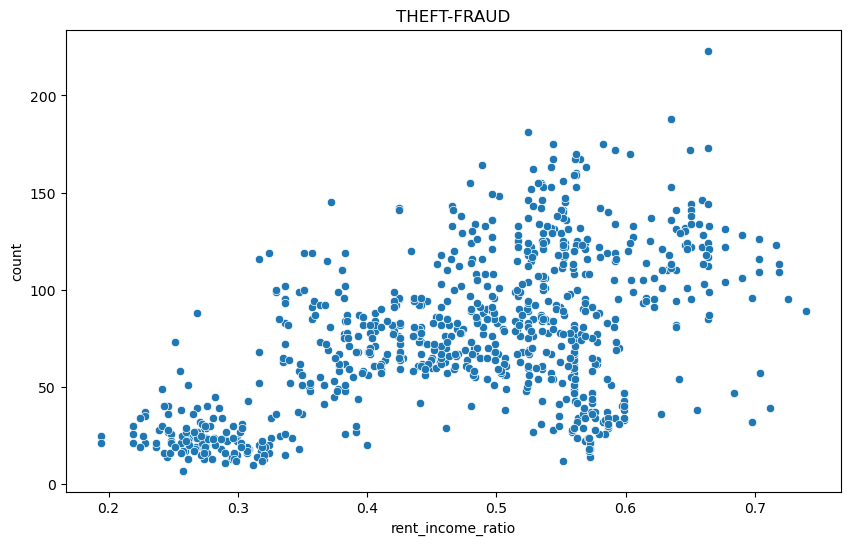

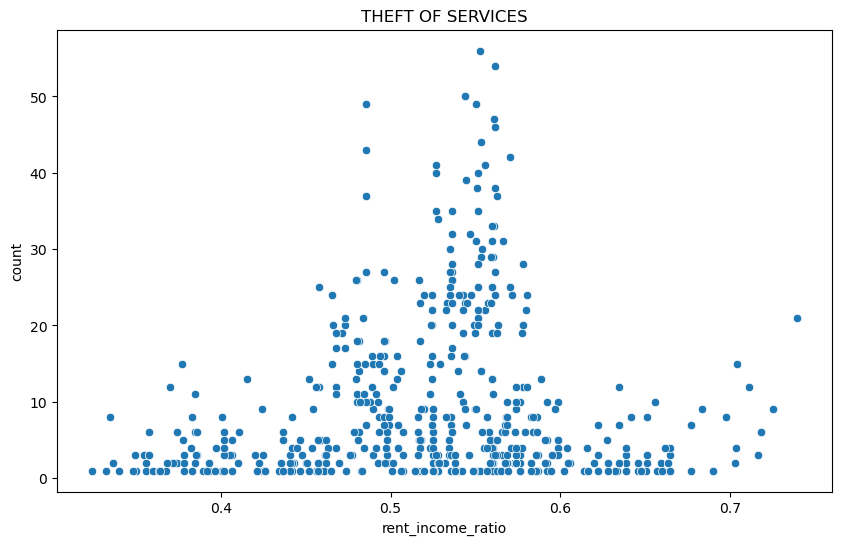

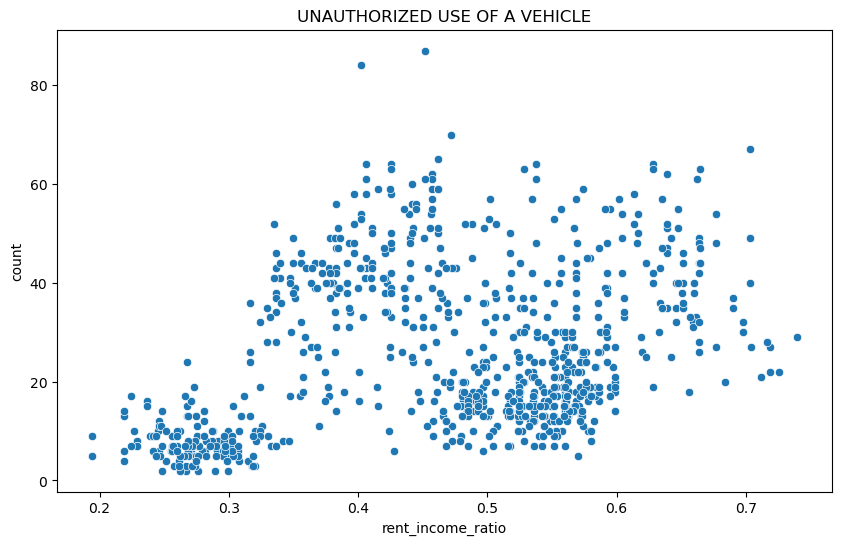

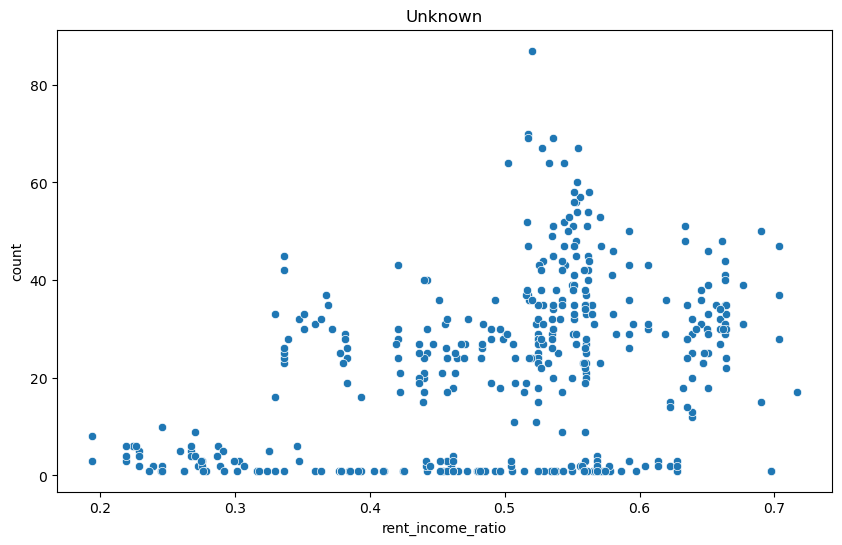

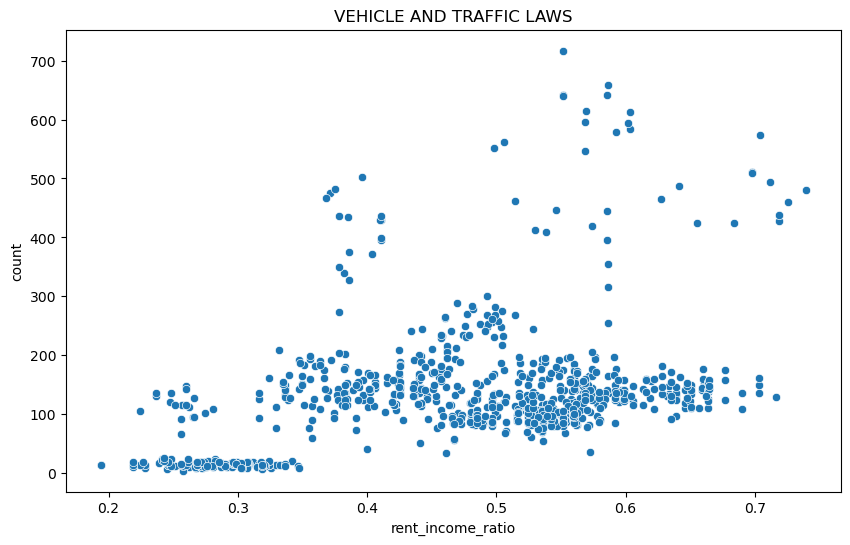

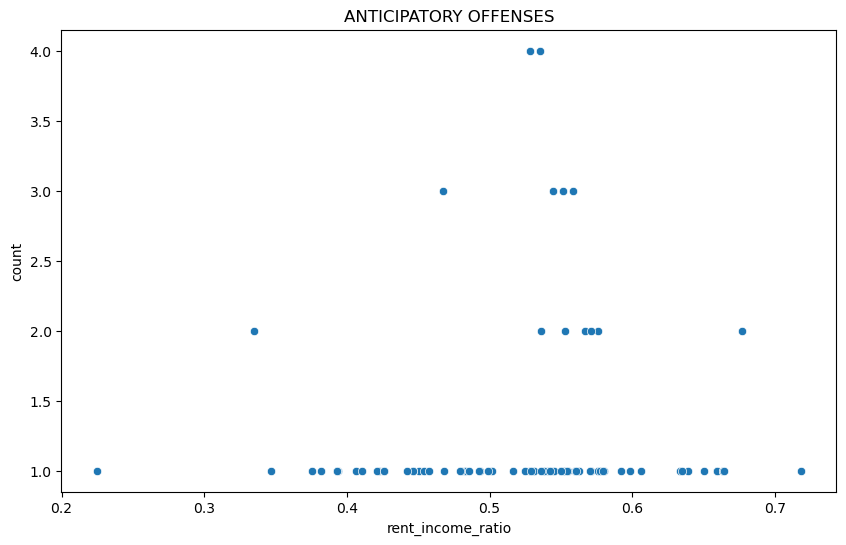

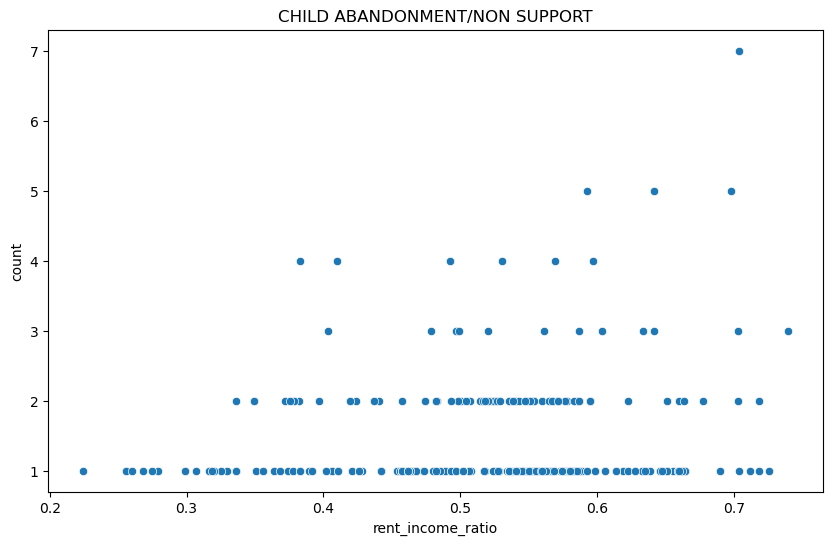

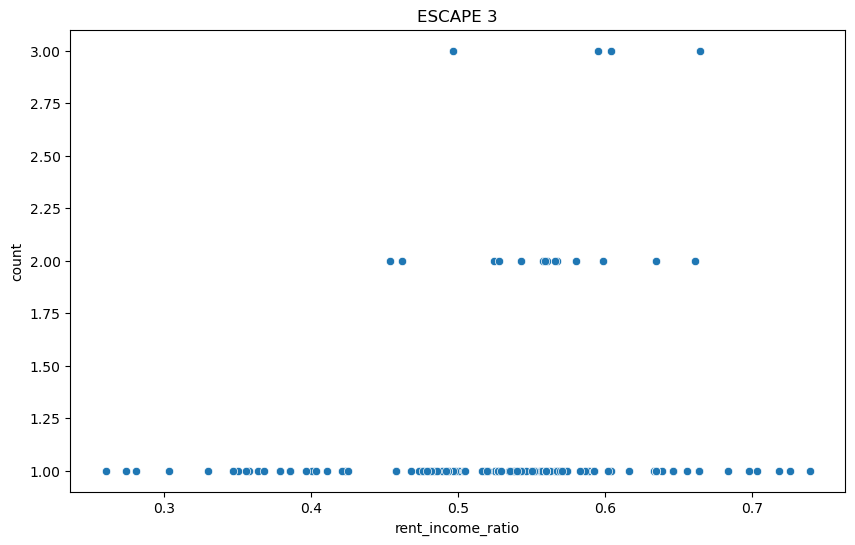

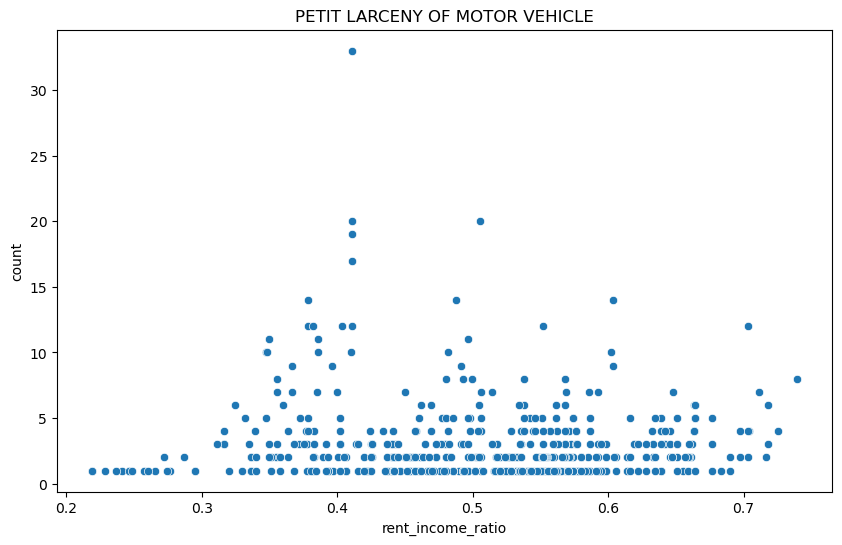

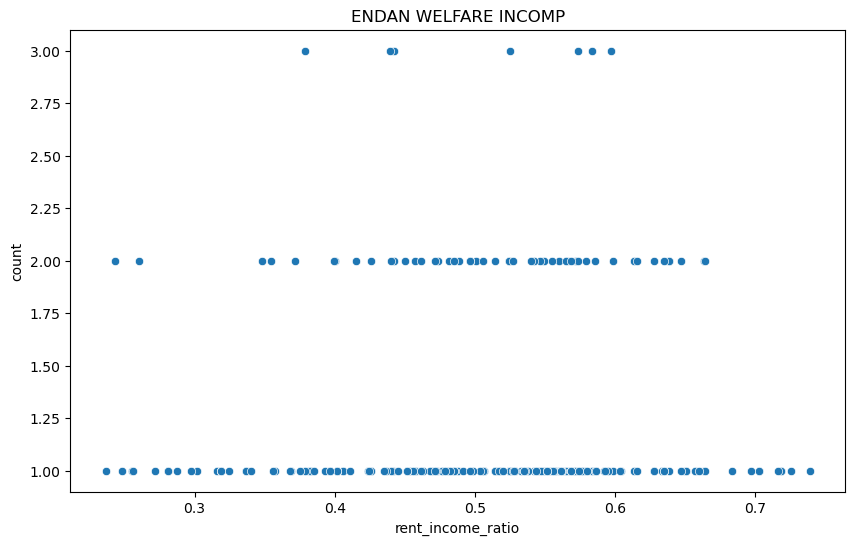

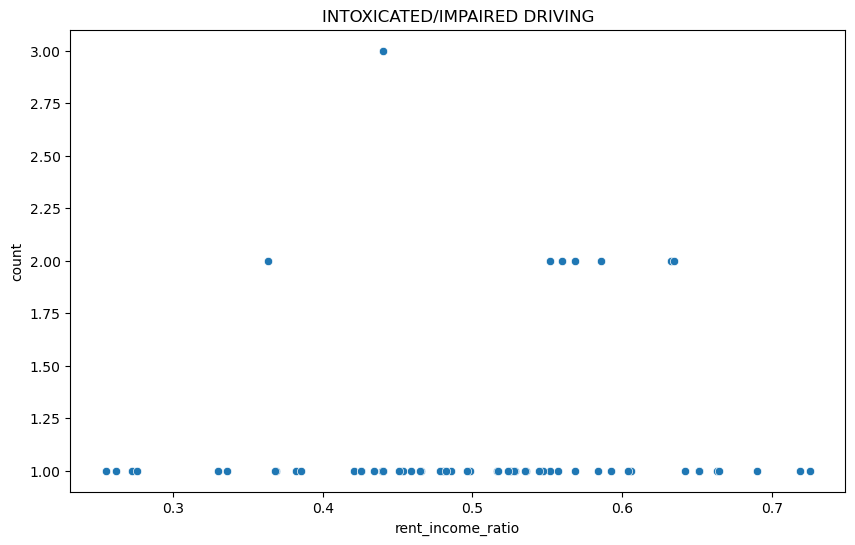

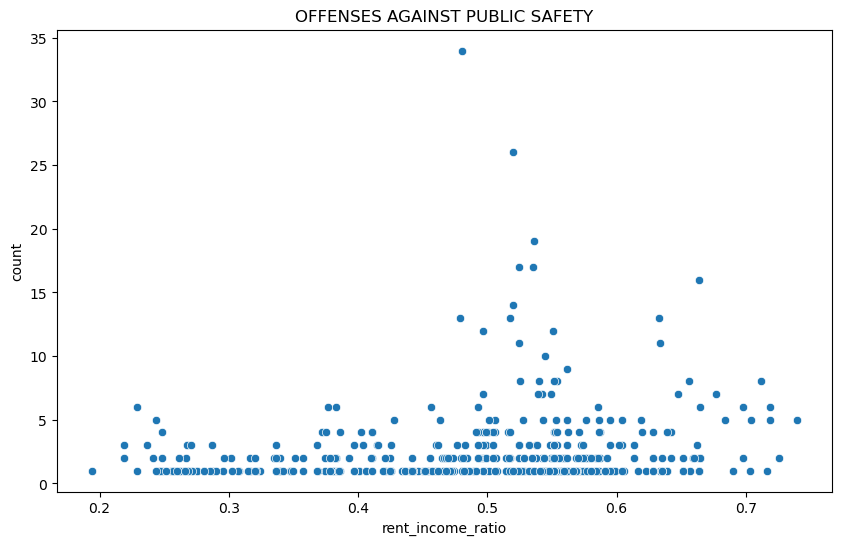

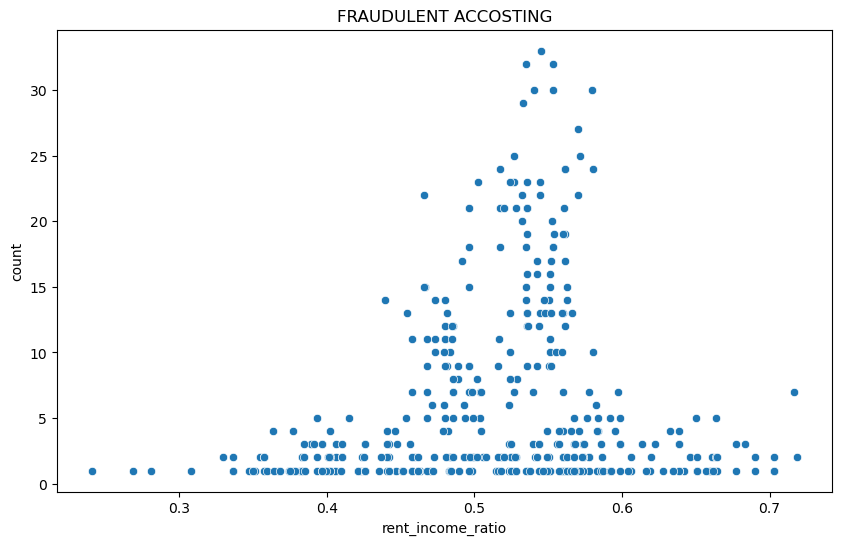

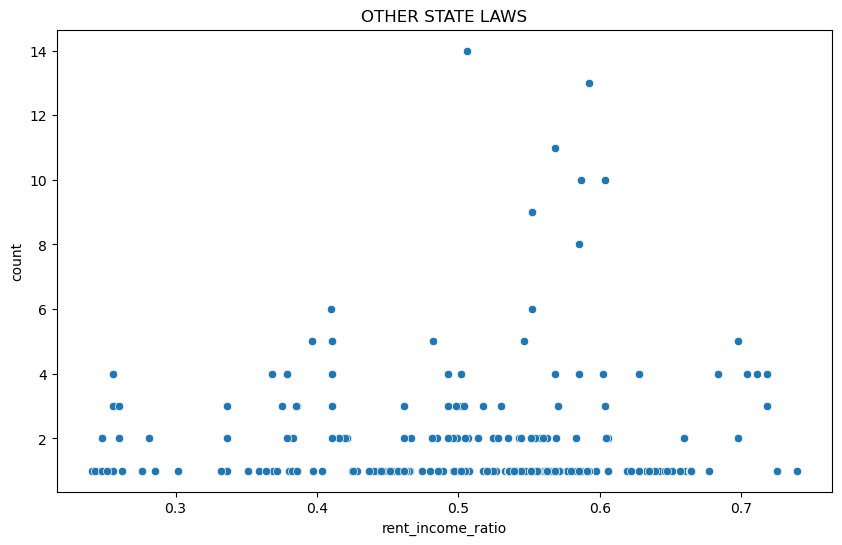

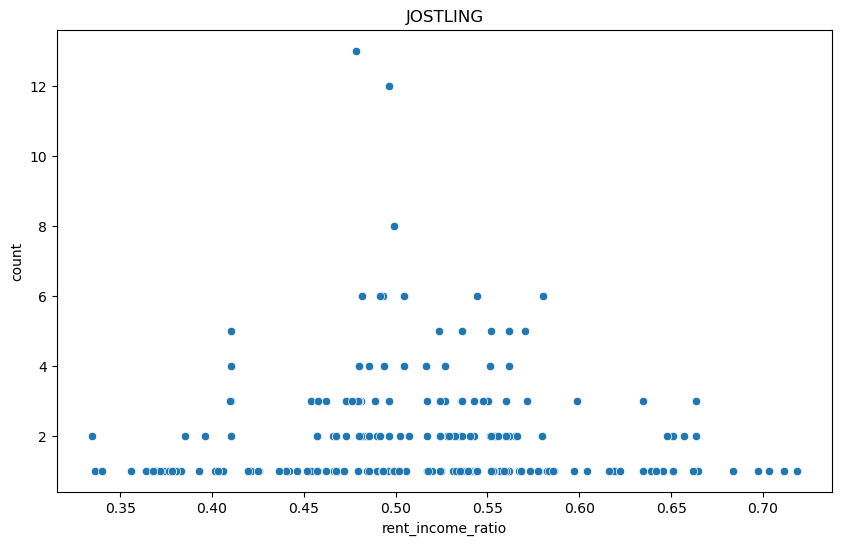

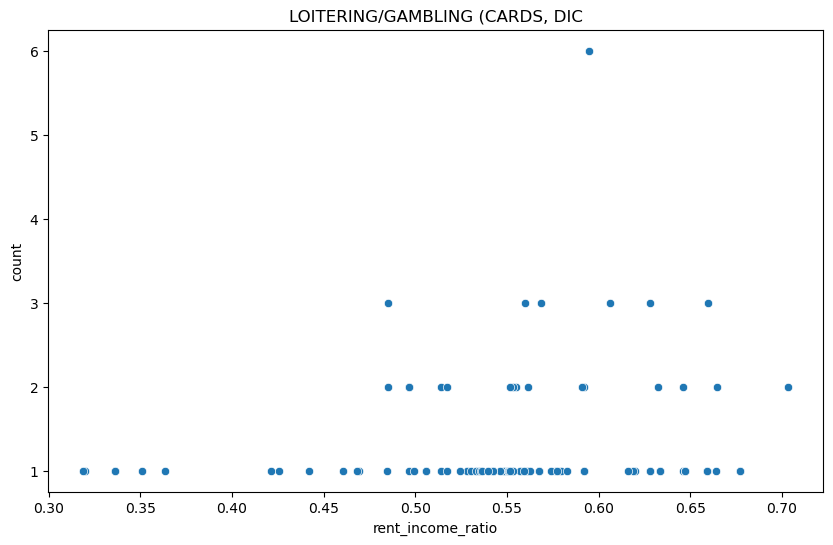

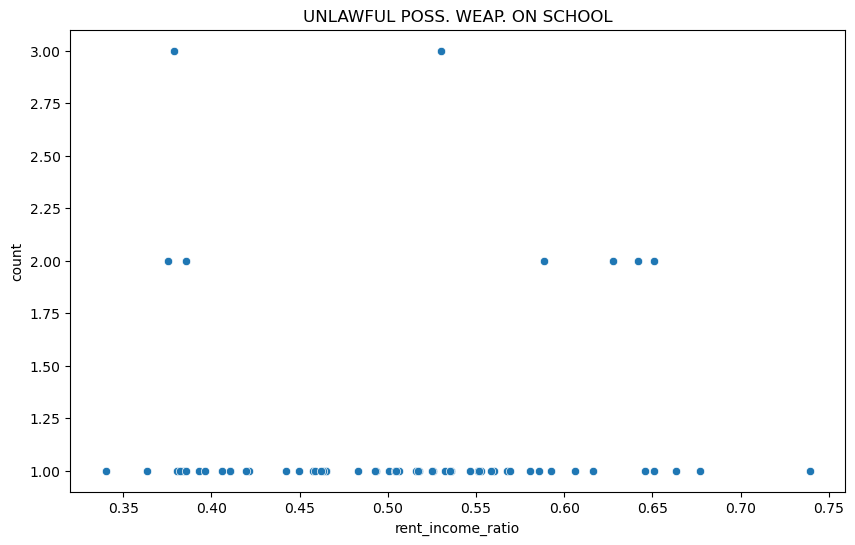

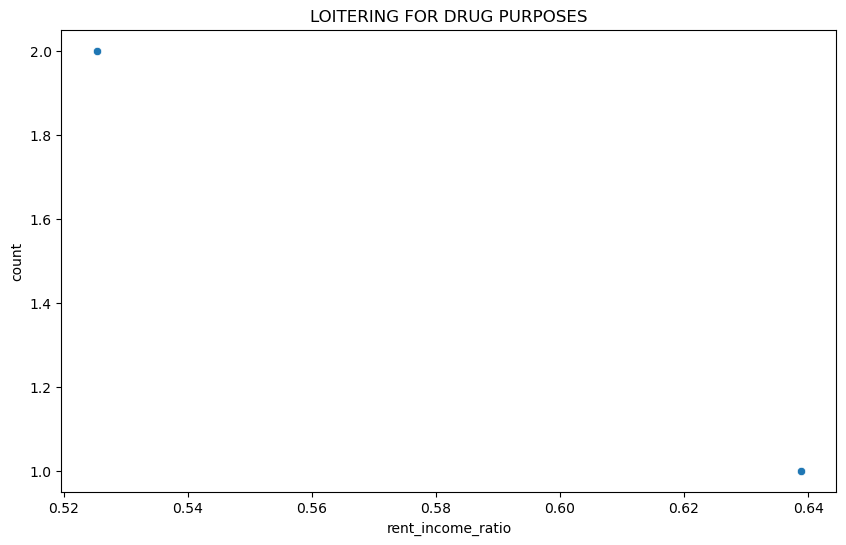

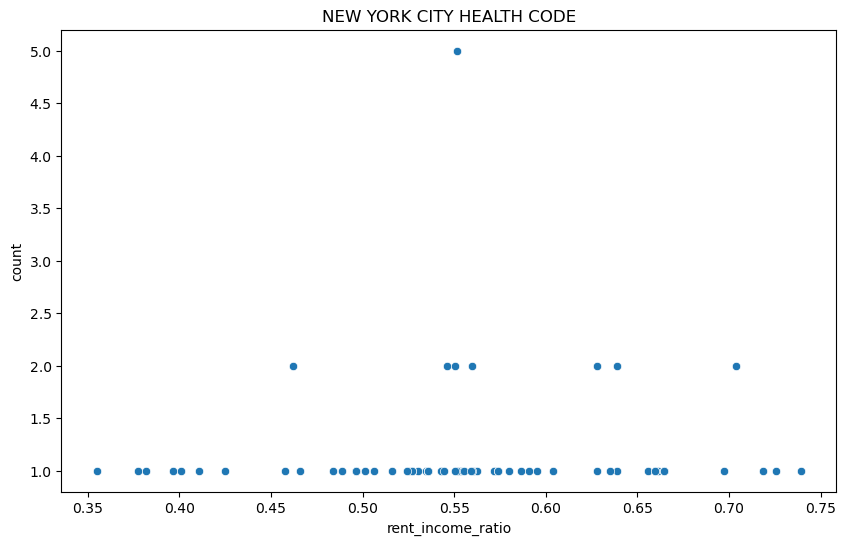

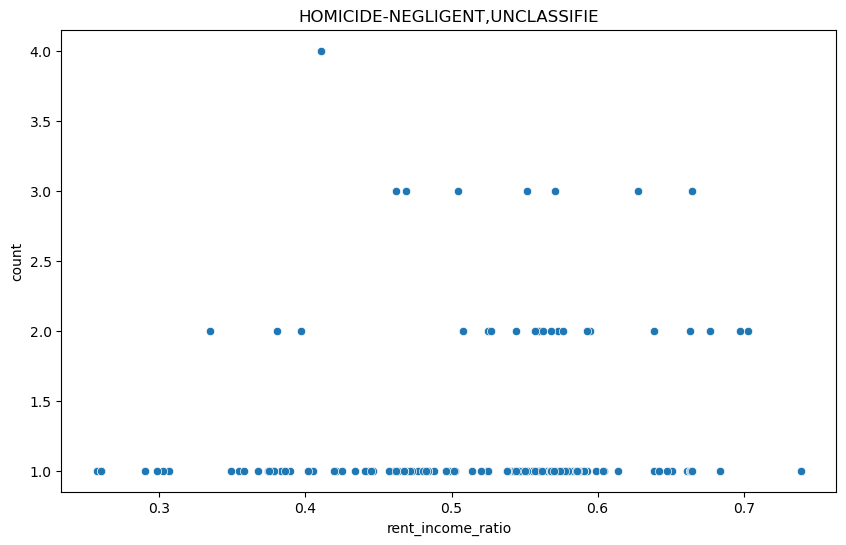

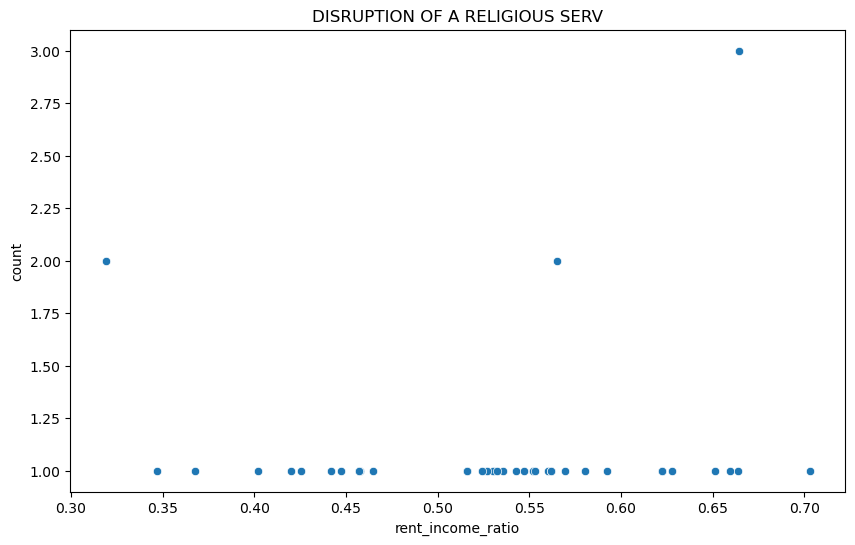

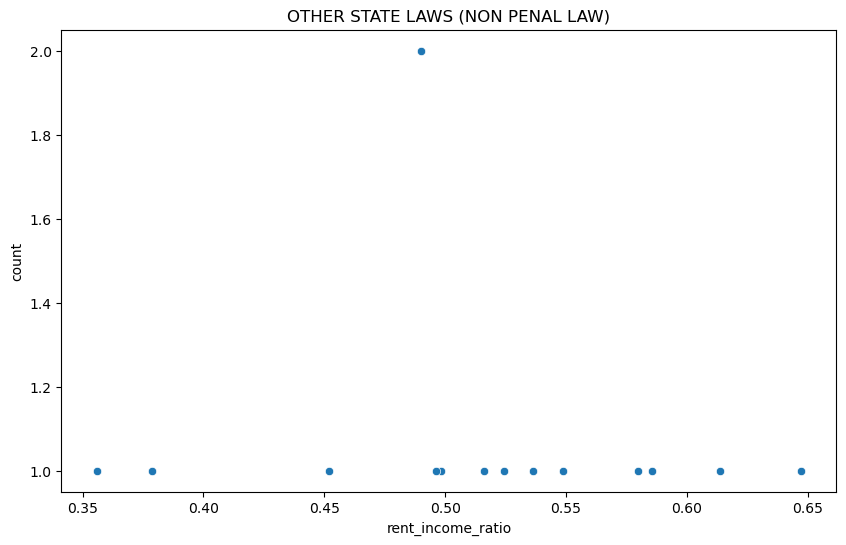

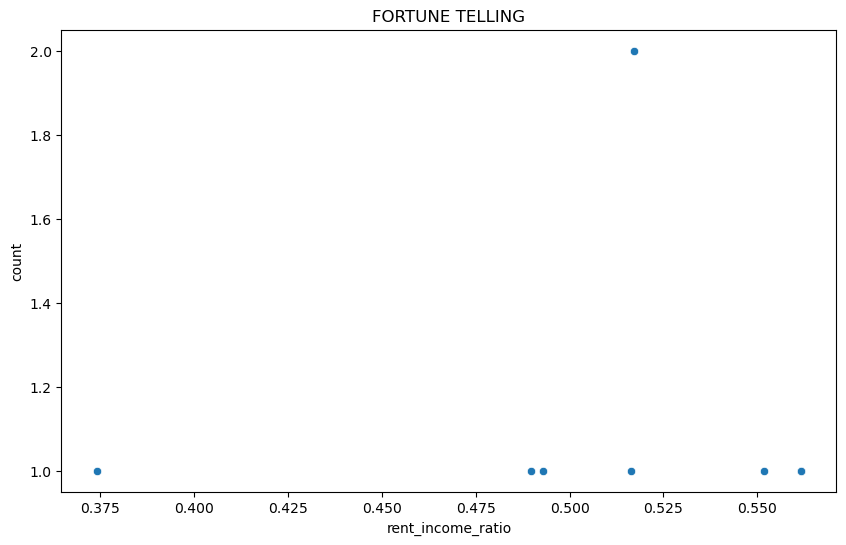

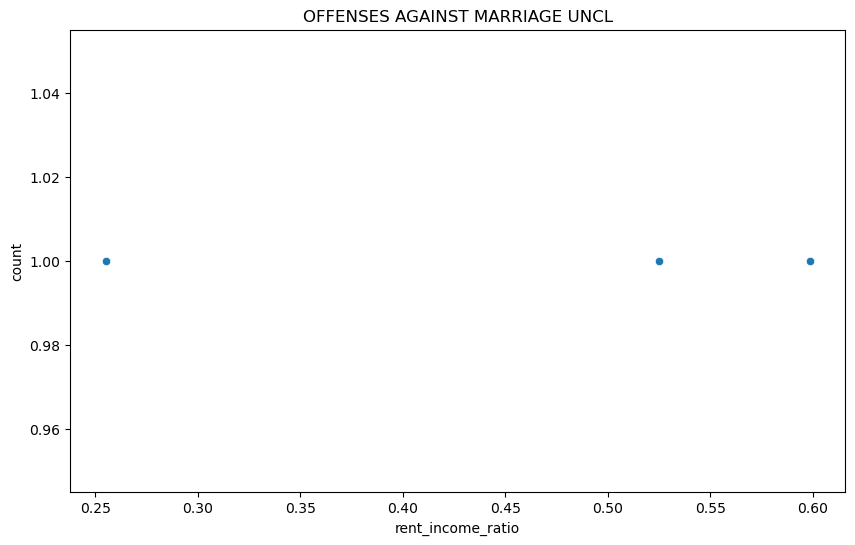

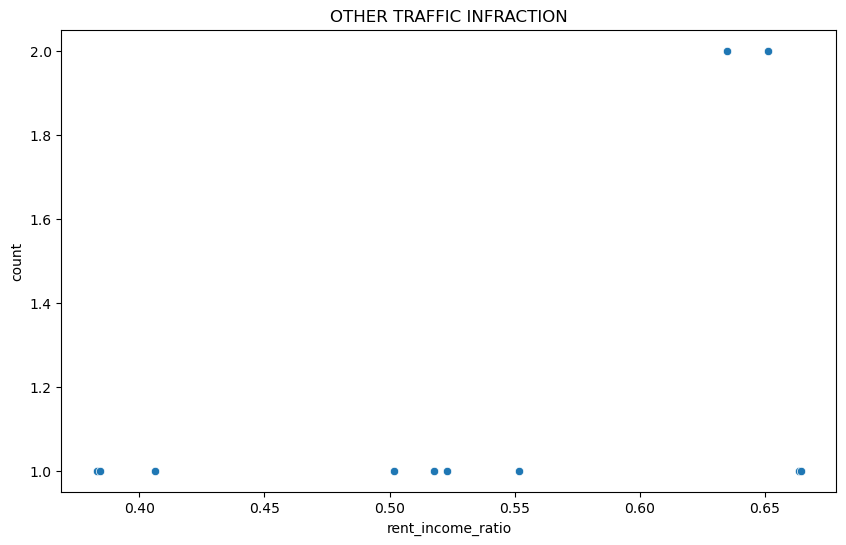

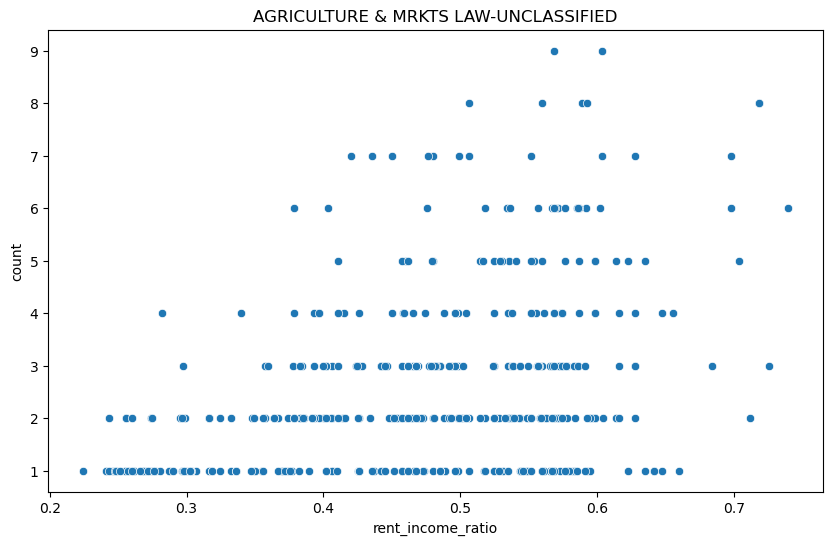

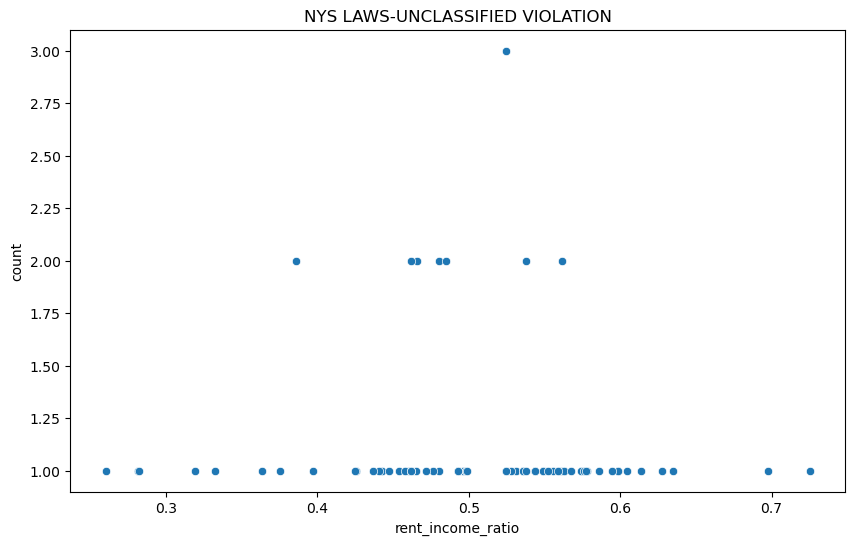

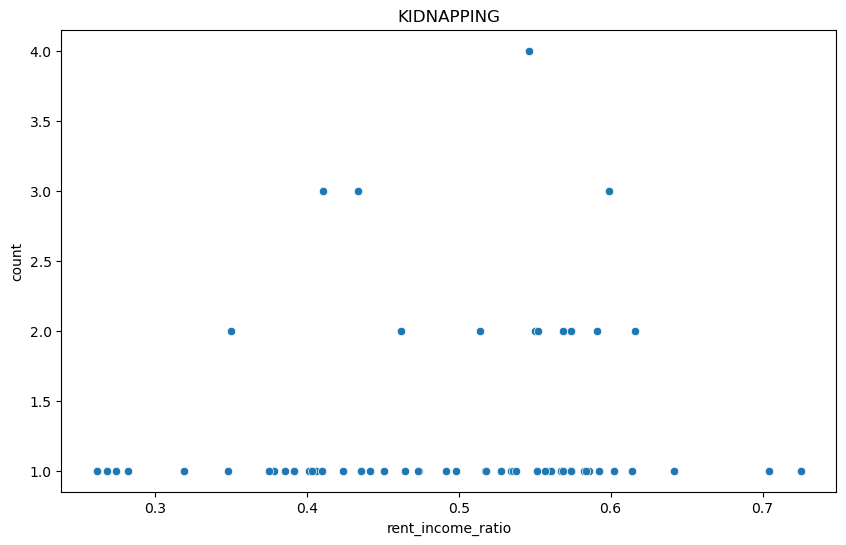

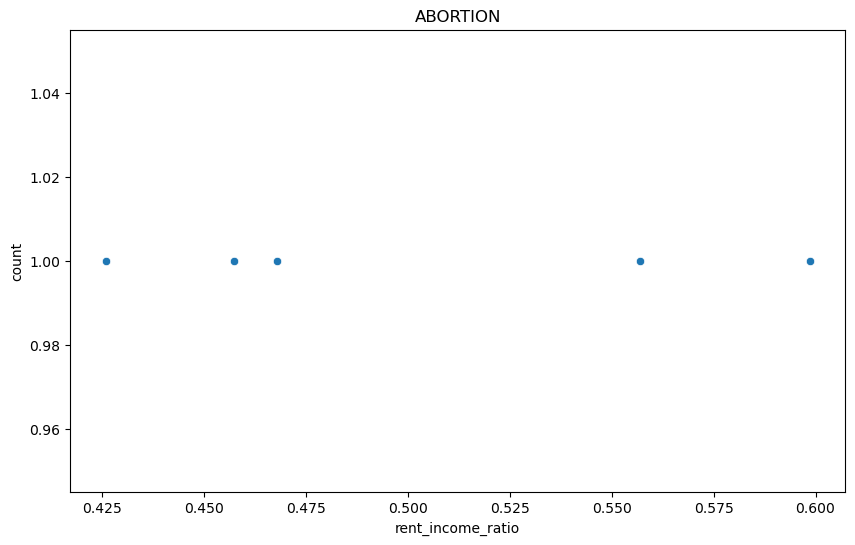

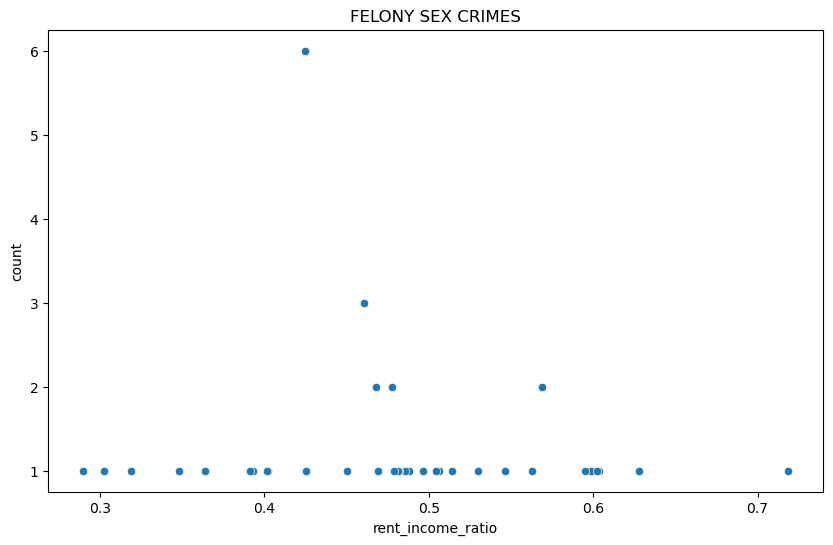

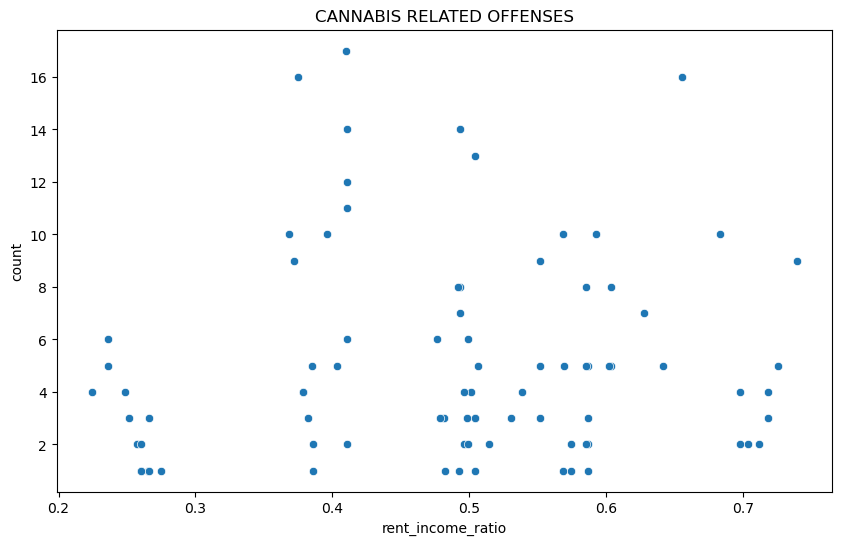

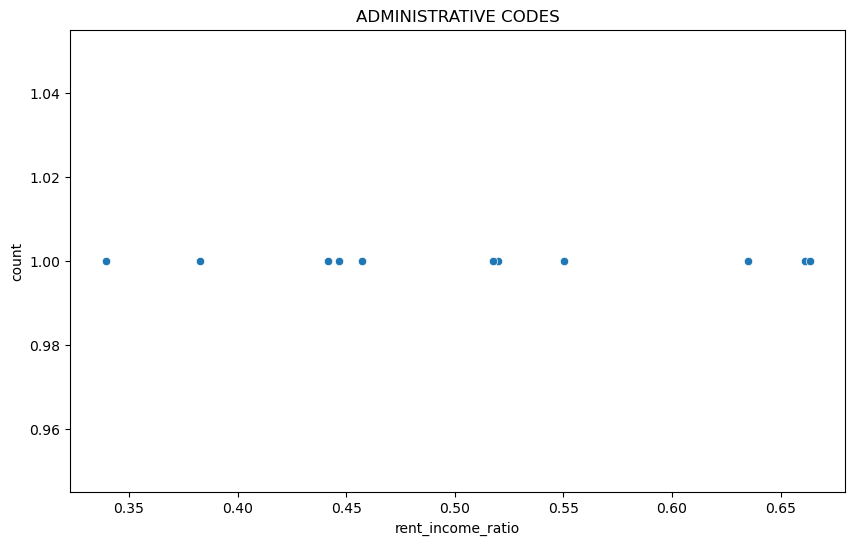

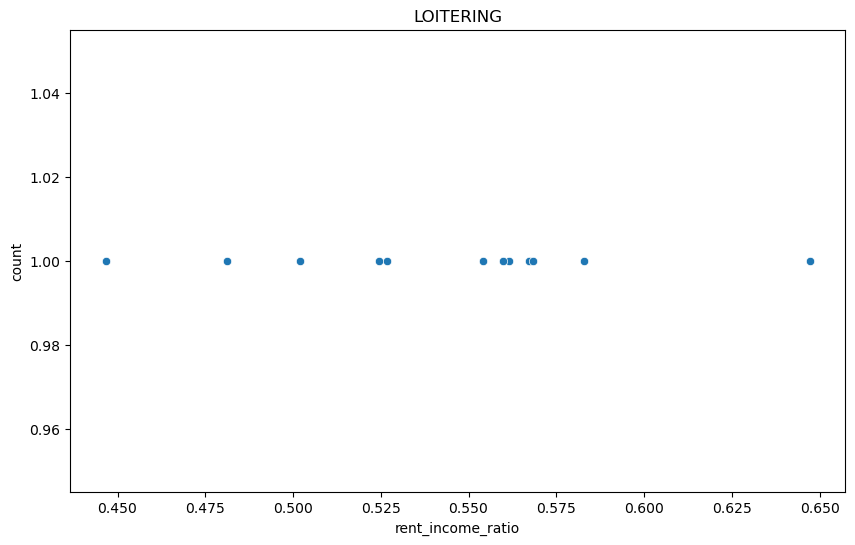

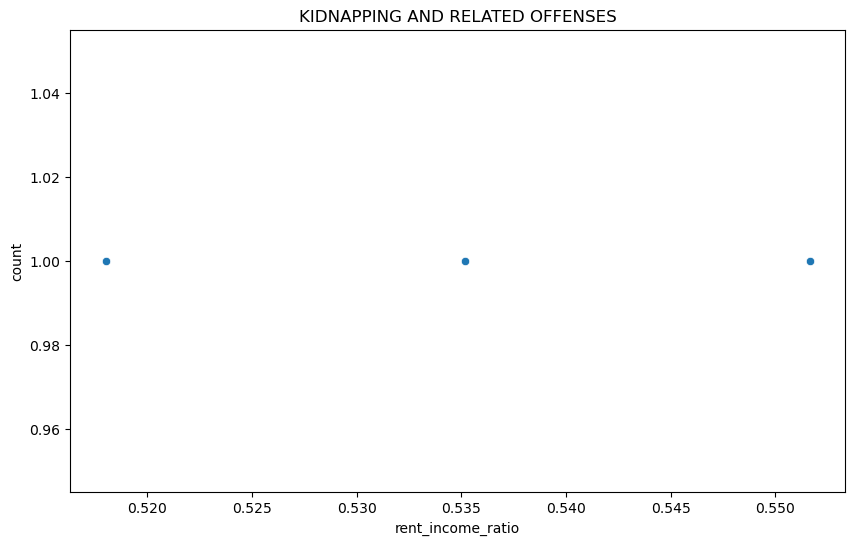

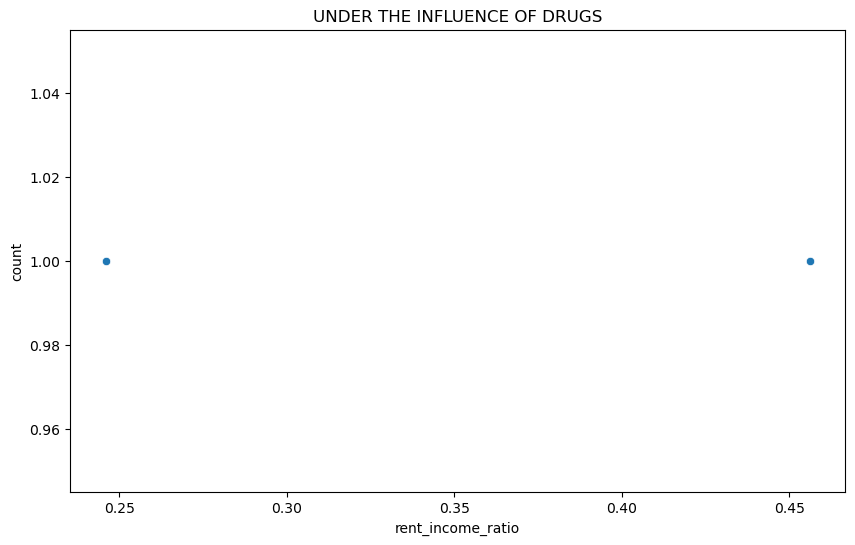

In [28]:


for offense in merged_data['offense'].unique():
    offense_data = merged_data[merged_data['offense'] == offense]
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=offense_data, x='rent_income_ratio', y='count')
    
    plt.title(offense)
    
    plt.show()


In [30]:
# Assuming 'merged_data' is your DataFrame
correlations = {}

# For each unique offense
for offense in merge['offense'].unique():
    # Filter the data for the current offense
    offense_data = merge[merge['offense'] == offense]
    
    # Calculate the Pearson's correlation coefficient
    correlation = offense_data['count'].corr(offense_data['rent_income_ratio'])
    
    # Store the correlation in the dictionary
    correlations[offense] = correlation

# Convert the dictionary to a pandas Series for easier sorting
correlations_series = pd.Series(correlations)

# Sort the correlations in descending order
sorted_correlations = correlations_series.sort_values(ascending=False)

print(sorted_correlations.to_string())


NameError: name 'merge' is not defined

In [ ]:
print(sorted_correlations.to_string())



In [ ]:
unemployment_data = get_dataframe(f'select year, month, borough, unemprate from {schema}.unemployment_nyc')

unemployment_data

In [ ]:
merged_data2 = pd.merge(unemployment_data, crimes_by_offense, on=['borough', 'year', 'month'])


In [ ]:
merged_data2

In [ ]:
# Assuming 'merged_data' is your DataFrame
correlations = {}

# For each unique offense
for offense in merged_data2['offense'].unique():
    # Filter the data for the current offense
    offense_data2 = merged_data2[merged_data2['offense'] == offense]
    
    # Calculate the Pearson's correlation coefficient
    correlation = offense_data2['count'].corr(offense_data2['unemprate'])
    
    # Store the correlation in the dictionary
    correlations[offense] = correlation

# Convert the dictionary to a pandas Series for easier sorting
correlations_series = pd.Series(correlations)

# Sort the correlations in descending order
sorted_correlations = correlations_series.sort_values(ascending=False)

print(sorted_correlations.to_string())

